In [1]:
## Adding path
import sys
from os import listdir
sys.path.append('../../Beltway_Project/')
sys.path.append('../../RatterdamOpen_Project/')
sys.path.append('../DATA/')
sys.path.append('../../../ratterdam/')

import RateMapClass_William_20190308 as RateMapClass
import confounds as direction
import ratterdam_RepetitionCoreFx as CoreFx


import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import seaborn as sb

import scipy
import pandas as pd

import pickle
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [2]:
## try 1.2
datadir = '/Users/maanasa/Desktop/JHU_RESEARCH/ratterdam/maanasa/DATA/R859_RatterdamOpen_D2/'
tetrode = 'TT1/'
eachfile = 'cl-maze1.2'
data = CoreFx.loadRepeatingUnit(datadir, tetrode, tetrode+eachfile)

/Users/maanasa/Desktop/JHU_RESEARCH/ratterdam/maanasa/DATA/R859_RatterdamOpen_D2/
R859
D2
False
[]
dict_keys([])


In [5]:
##https://www.geeksforgeeks.org/find-the-centroid-of-a-non-self-intersecting-closed-polygon/
## mohit kumar
def find_Centroid(v):
    ans = [0, 0]
 
    n = len(v)
    signedArea = 0
 
    # For all vertices
    for i in range(len(v)):
 
        x0 = v[i][0]
        y0 = v[i][1]
        x1 = v[(i + 1) % n][0]
        y1 =v[(i + 1) % n][1]
 
        # Calculate value of A
        # using shoelace formula
        A = (x0 * y1) - (x1 * y0)
        signedArea += A
 
        # Calculating coordinates of
        # centroid of polygon
        ans[0] += (x0 + x1) * A
        ans[1] += (y0 + y1) * A
 
    signedArea *= 0.5
    ##print(signedArea)
    ans[0] = (ans[0]) / (6 * signedArea)
    ans[1] = (ans[1]) / (6 * signedArea)
 
    return ans, signedArea

In [5]:
datadir = '../DATA/R859_RatterdamOpen_D2/'
all_dir = listdir(datadir)
for each_dir in all_dir:
    if 'TT' in each_dir:

        tetrode = each_dir + '/'
        print(tetrode)
        allfiles = listdir(datadir + tetrode)
        
        for eachfile in allfiles:   
            if 'cl-maze' in eachfile and 'OLD' not in eachfile:
                data = CoreFx.loadRepeatingUnit(datadir, tetrode, tetrode+eachfile)
                sum_area = 0
                sum_area_threshold = 50000
                if len(data.perimeters) > 0:
                    time = np.array(data.position)[:,0]
                    x = np.array(data.position)[:,1]
                    y = np.array(data.position)[:,2]
                    plt.scatter(x,y)
                    for j in range(len(data.perimeters)):
                        plt.scatter(data.perimeters[j][:,0], data.perimeters[j][:,1])
                        sum_area = sum_area + find_Centroid(data.perimeters[j])[1]
                    plt.title(eachfile)
                    plt.show()
                if sum_area< sum_area_threshold:
                    all_field_centroids = field_finder_time(data,datadir, tetrode, eachfile)
                    [all_added, all_removed, num_fields] = field_added_removed_finder(all_field_centroids) 

TT13/
/Users/maanasa/Desktop/JHU_RESEARCH/ratterdam_maanasa/maanasa/DATA/R859_RatterdamOpen_D2/
R859
D2
TT13cl-maze1.1_manuallyRedrawnFields.json


FileNotFoundError: [Errno 2] No such file or directory: '/Users/maanasa/Desktop/JHU_RESEARCH/ratterdam_maanasa/maanasa/DATA/R859_RatterdamOpen_D2/manuallyRedrawnFields\\'

In [3]:
def field_finder_time(data, datadir, tetrode, eachfile):
    dt = 10000
    all_field_centroids= []
    for i in range(0, int(np.floor(len(data.position)/dt))):
        ##timebreaks = alltime[0:len(alltime):dt][1:]
        p = data.position[dt*i:(i+1)*dt,]
        s = data.spikes[data.spikes[:,0] <p[-1][0]]
        s = s[s[:,0]>p[0][0]]
        ##print(s)
        new_1 = CoreFx.loadRepeatingUnitTemporal(s,p,datadir,tetrode+eachfile, True)
        print(i,len(new_1.fields))
        if len(new_1.perimeters) > 0:

            x = np.array(data.position)[:,1]
            y = np.array(data.position)[:,2]
            plt.plot(x,y,'o')
            field_centroids = []
            for j in range(len(new_1.perimeters)):
                vp = new_1.perimeters[j]
                ans = find_Centroid(vp)[0]
                plt.plot(ans[0],ans[1],'ro')
                plt.plot(new_1.perimeters[j][:,0], new_1.perimeters[j][:,1],'r')
                field_centroids.append(ans)
            all_field_centroids.append(field_centroids)
            plt.title(i)
            plt.xlim(0,600)
            plt.ylim(0,500)
            plt.show()
        else:
            all_field_centroids.append([])
    return(all_field_centroids)
        

(0.0, 500.0)

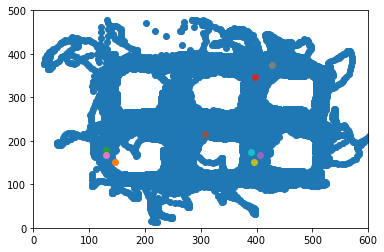

In [8]:
x = np.array(data.position)[:,1]
y = np.array(data.position)[:,2]
plt.plot(x,y,'o')
for i in range(len(all_field_centroids)):
    for j in range(len(all_field_centroids[i])):
        plt.plot(all_field_centroids[i][j][0],all_field_centroids[i][j][1],'o')
                 
plt.xlim(0,600)
plt.ylim(0,500)

In [4]:
def field_added_removed_finder(all_field_centroids): 
    all_distances = []
    all_added = []
    all_unique_added = []
    all_removed = []
    num_fields = [len(all_field_centroids[0])]
    dist_th = 50
    for i in range(1,len(all_field_centroids)):
        num_fields.append(len(all_field_centroids[i]))
        distances = []
        added = len(all_field_centroids[i])
        removed = len(all_field_centroids[i-1])
        ##print(added, removed)
        for j in range(len(all_field_centroids[i])):
            xcurr = all_field_centroids[i][j][0]
            ycurr = all_field_centroids[i][j][1]
            for k in range(len(all_field_centroids[i-1])):
                xprev = all_field_centroids[i-1][k][0]
                yprev = all_field_centroids[i-1][k][1]
                ##print(xprev, yprev)
                dis = (((xcurr-xprev)**2) + ((ycurr-yprev)**2))**.5
                distances.append(dis)
                plt.plot(i, dis, 'o')
            if len(distances)>0 and (np.min(distances))< dist_th:
                added = added-1
                removed = removed-1
        all_added.append(added)
        all_removed.append(removed)

        all_distances.append(distances)
    plt.show()
    plt.plot(np.arange(1,len(all_added)+1),all_added, label = 'added')
    plt.plot(np.arange(1,len(all_removed)+1),all_removed, label = 'removed')
    plt.plot(np.arange(0,len(num_fields)),num_fields, 'o',label = 'number of fields')
    plt.legend()
    plt.show()
    return(all_added, all_removed, num_fields)

In [9]:
file = open('maanasa/DATA/20220405-124315_superPopulationRepetition.pickle','rb')
alldat = pickle.load(file)

In [368]:
## run on all rats, all days
dt = 10000
thresh_mult = 0.3
h = 10**-12
allrats = alldat.keys()
all_titles = []
all_rats_fields_added = []
all_rats_fields_removed = []
all_rats_fields_present = []
for rat in allrats:
    days = alldat[rat].keys()
    for day in days:
        all_titles.append(rat + day)
        print(rat, day)
        all_cells = alldat[rat][day]['units'].keys()
        all_fields_added = []
        all_fields_removed = []
        all_fields_present = []
        all_thresholds = []
        for each_cell in all_cells:
            print(each_cell)
            data = alldat[rat][day]['units'][each_cell]
            if data.repeating == False:
                num_times = int(np.floor(len(data.position)/dt))
                all_num_spikes = np.zeros(num_times)
                all_time_spent = np.zeros(num_times)

                ##allfields_percell = np.full((len(data.perimeters),  num_times), True)
                fields_added = np.zeros(num_times-1)
                fields_removed = np.zeros(num_times-1)
                fields_present = np.zeros(num_times)
                for field_counter in range(len(data.perimeters)):
                    coordPolygon = Polygon(data.perimeters[field_counter])
                    for i in range(0, num_times):     
                        p = data.position[dt*i:(i+1)*dt,]
                        s = data.spikes[data.spikes[:,0] <p[-1][0]]
                        s = s[s[:,0]>p[0][0]]
                        num_spikes = 0
                        for eachs in range(len(s)):
                            coordPoint = Point(s[eachs,1],s[eachs,2])
                            if coordPolygon.contains(coordPoint) == True:
                                num_spikes = num_spikes + 1
                        num_time_spent = 0
                        for eachp in range(len(p)):
                            coordPoint = Point(p[eachp,1],p[eachp,2])
                            if coordPolygon.contains(coordPoint) == True:
                                num_time_spent  = num_time_spent + 1
                        if num_time_spent == 0:
                            num_time_spent = h
                        ##print(i,num_spikes, num_time_spent, num_spikes/num_time_spent)
                        all_num_spikes[i] = num_spikes
                        all_time_spent[i] = num_time_spent
                    avg_all = np.sum(all_num_spikes)/np.sum(all_time_spent)
                    ##print(avg_all)    
                    ##print(all_num_spikes/all_time_spent> (avg_all*thresh_mult))
                    field_bool = all_num_spikes/all_time_spent> (avg_all*thresh_mult)
                    ##allfields_percell[field_counter, :] = field_bool
                    all_thresholds.append(avg_all*thresh_mult)
                    for change_counter in range(len(field_bool)):
                        fields_present[change_counter]= fields_present[change_counter] + int(field_bool[change_counter])
                        if change_counter>0:
                            if field_bool[change_counter-1] == True and field_bool[change_counter] == False:
                                fields_removed[change_counter-1] = fields_removed[change_counter-1] + 1
                            elif field_bool[change_counter-1] == False and field_bool[change_counter] == True:
                                fields_added[change_counter-1] = fields_added[change_counter-1] + 1
                ##print(fields_added)
                ##print(fields_removed)
                ##print(fields_present)
                all_fields_added.append(fields_added)
                all_fields_removed.append(fields_removed)
                all_fields_present.append(fields_present)
        all_rats_fields_added.append(np.array(all_fields_added))
        all_rats_fields_removed.append(np.array(all_fields_removed))
        all_rats_fields_present.append(np.array(all_fields_present))






R765 RFD5
TT10\cl-maze1.2
TT10\cl-maze1.3
TT13\cl-maze1.1
TT13\cl-maze1.2
TT13\cl-maze1.3
TT15\cl-maze1.1
TT15\cl-maze1.2
TT15\cl-maze1.3
TT15\cl-maze1.4
TT15\cl-maze1.7
TT4\cl-maze1.10
TT4\cl-maze1.11
TT4\cl-maze1.12
TT4\cl-maze1.14
TT4\cl-maze1.3
TT4\cl-maze1.4
TT4\cl-maze1.5
TT4\cl-maze1.7
TT4\cl-maze1.8
TT4\cl-maze1.9
TT6\cl-maze1.1
TT7\cl-maze1.1
R765 DFD4
TT1\cl-maze1.1
TT1\cl-maze1.2
TT10\cl-maze1.2
TT10\cl-maze1.3
TT10\cl-maze1.4
TT11\cl-maze1.1
TT11\cl-maze1.2
TT11\cl-maze1.3
TT14\cl-maze1.1
TT14\cl-maze1.2
TT14\cl-maze1.3
TT14\cl-maze1.4
TT15\cl-maze1.1
TT15\cl-maze1.3
TT15\cl-maze1.5
TT4\cl-maze1.2
TT4\cl-maze1.3
TT4\cl-maze1.4
TT4\cl-maze1.5
TT4\cl-maze1.7
TT7\cl-maze1.1
TT7\cl-maze1.2
TT7\cl-maze1.3
TT7\cl-maze1.4
TT7\cl-maze1.5
TT7\cl-maze1.6
TT7\cl-maze1.8
TT7\cl-maze1.9
TT8\cl-maze1.1
TT8\cl-maze1.2
TT8\cl-maze1.3
TT8\cl-maze1.4
R781 D3
TT11\cl-maze1.1
TT11\cl-maze1.2
TT14\cl-maze1.1
TT2\cl-maze1.2
TT2\cl-maze1.5
TT3\cl-maze1.1
TT3\cl-maze1.2
TT3\cl-maze1.5
TT3\cl-maze1

In [140]:
dt = 10000
thresh_mult = 0.1
h = 10**-12

all_cells = alldat['R859']['D2']['units'].keys()
all_fields_added = []
all_fields_removed = []
all_fields_present = []
all_thresholds = []
for each_cell in all_cells:
    print(each_cell)
    data = alldat['R859']['D2']['units'][each_cell]
    num_times = int(np.floor(len(data.position)/dt))
    all_num_spikes = np.zeros(num_times)
    all_time_spent = np.zeros(num_times)
    
    ##allfields_percell = np.full((len(data.perimeters),  num_times), True)
    fields_added = np.zeros(num_times-1)
    fields_removed = np.zeros(num_times-1)
    fields_present = np.zeros(num_times)
    for field_counter in range(len(data.perimeters)):
        coordPolygon = Polygon(data.perimeters[field_counter])
        for i in range(0, num_times):     
            p = data.position[dt*i:(i+1)*dt,]
            s = data.spikes[data.spikes[:,0] <p[-1][0]]
            s = s[s[:,0]>p[0][0]]
            num_spikes = 0
            for eachs in range(len(s)):
                coordPoint = Point(s[eachs,1],s[eachs,2])
                if coordPolygon.contains(coordPoint) == True:
                    num_spikes = num_spikes + 1
            num_time_spent = 0
            for eachp in range(len(p)):
                coordPoint = Point(p[eachp,1],p[eachp,2])
                if coordPolygon.contains(coordPoint) == True:
                    num_time_spent  = num_time_spent + 1
            if num_time_spent == 0:
                num_time_spent = h
            ##print(i,num_spikes, num_time_spent, num_spikes/num_time_spent)
            all_num_spikes[i] = num_spikes
            all_time_spent[i] = num_time_spent
        avg_all = np.sum(all_num_spikes)/np.sum(all_time_spent)
        ##print(avg_all)    
        ##print(all_num_spikes/all_time_spent> (avg_all*thresh_mult))
        field_bool = all_num_spikes/all_time_spent> (avg_all*thresh_mult)
        ##allfields_percell[field_counter, :] = field_bool
        all_thresholds.append(avg_all*thresh_mult)
        for change_counter in range(len(field_bool)):
            fields_present[change_counter]= fields_present[change_counter] + int(field_bool[change_counter])
            if change_counter>0:
                if field_bool[change_counter-1] == True and field_bool[change_counter] == False:
                    fields_removed[change_counter-1] = fields_removed[change_counter-1] + 1
                elif field_bool[change_counter-1] == False and field_bool[change_counter] == True:
                    fields_added[change_counter-1] = fields_added[change_counter-1] + 1
    ##print(fields_added)
    ##print(fields_removed)
    ##print(fields_present)
    all_fields_added.append(fields_added)
    all_fields_removed.append(fields_removed)
    all_fields_present.append(fields_present)



TT1\cl-maze1.1
TT1\cl-maze1.2
TT10\cl-maze1.2
TT10\cl-maze1.3
TT10\cl-maze1.4
TT10\cl-maze1.5
TT11\cl-maze1.10
TT11\cl-maze1.2
TT11\cl-maze1.3
TT11\cl-maze1.4
TT11\cl-maze1.5
TT11\cl-maze1.7
TT11\cl-maze1.9
TT12\cl-maze1.1
TT12\cl-maze1.2
TT12\cl-maze1.3
TT13\cl-maze1.1
TT13\cl-maze1.3
TT13\cl-maze1.4
TT13\cl-maze1.5
TT14\cl-maze1.1
TT14\cl-maze1.2
TT14\cl-maze1.5
TT14\cl-maze1.7
TT6\cl-maze1.1
TT6\cl-maze1.10
TT6\cl-maze1.4
TT6\cl-maze1.6
TT6\cl-maze1.7
TT6\cl-maze1.8
TT6\cl-maze1.9
TT7\cl-maze1.1
TT7\cl-maze1.2
TT7\cl-maze1.4
TT7\cl-maze1.5
TT7\cl-maze1.7
TT8\cl-maze1.1
TT8\cl-maze1.2
TT8\cl-maze1.5


Text(0.5, 1.0, 'all thresholds 0.1')

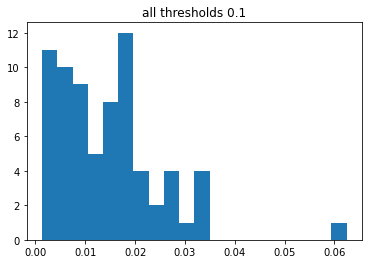

In [152]:
plt.hist(all_thresholds, bins = 20)
plt.title('all thresholds 0.1')

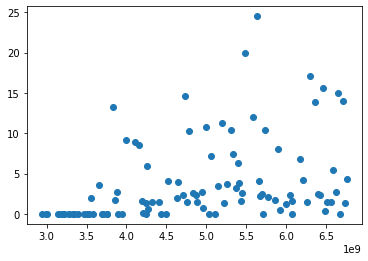

In [181]:
plt.plot(np.array(data.fields[i])[:,0], np.array(data.fields[i])[:,1],'o')


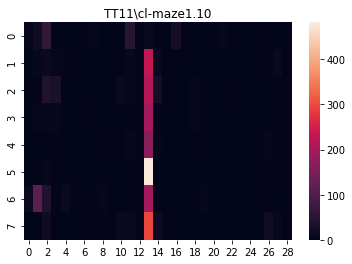

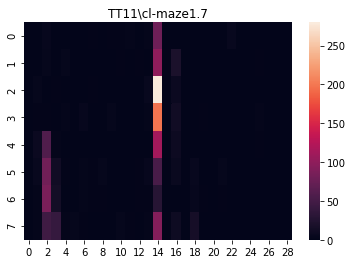

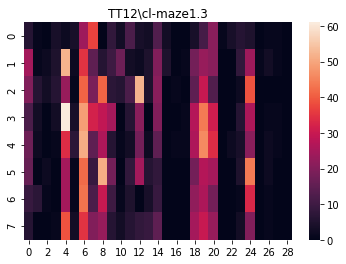

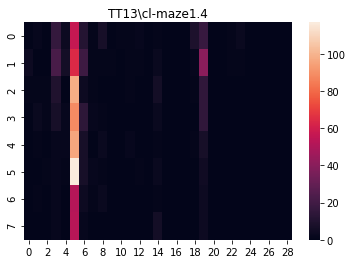

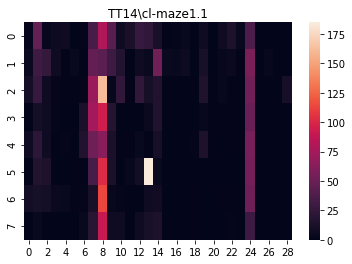

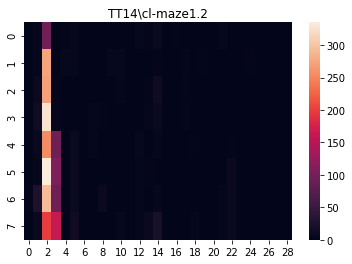

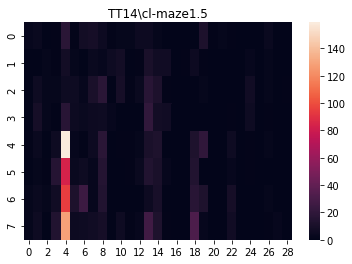

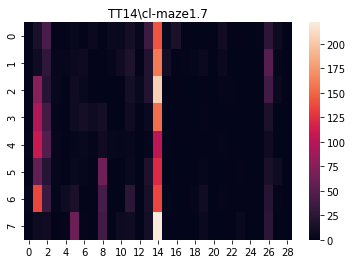

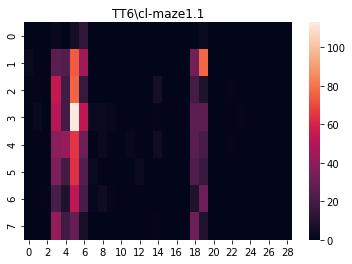

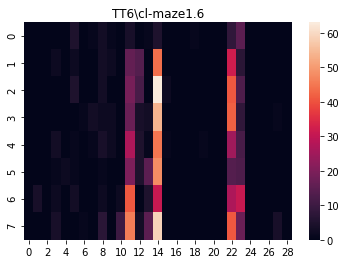

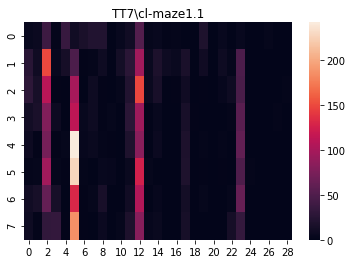

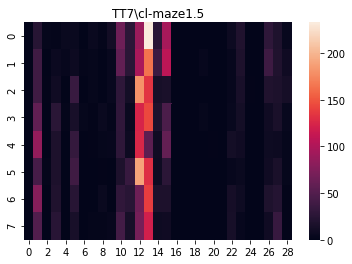

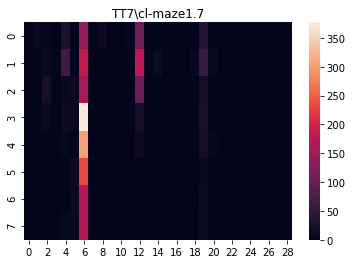

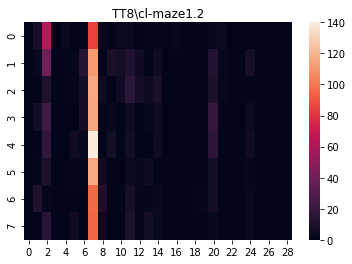

In [353]:
## getting only repeated ones

import newAlleyBounds2 as bounds2
timeall = data.position[:,0]
dt = 10000
alltime = timeall##np.array(data.position)[:,0]
timebreaks = alltime[0:len(alltime):dt][1:]
boundaries = bounds2.loadAlleyBounds('R859', 'D2')[-2]
bound_list = list(dict.keys(boundaries))

all_cells = alldat['R859']['D2']['units'].keys()
for each_cell in all_cells:
    data = alldat['R859']['D2']['units'][each_cell]
    if data.repeating == True:
        all_data_alley = np.zeros((len(timebreaks),len(bound_list)))
        x = data.spikes[:,1]
        y = data.spikes[:,2]
        time = data.spikes[:,0]
        time_counter = 0
        for i in range(0,len(x)):

            if time[i]>timebreaks[time_counter]:
                time_counter = time_counter+1
            if time_counter>len(timebreaks)-1:
                break
            for j in range(len(bound_list)): 
                alley = bound_list[j]
                if x[i] > boundaries[alley][0][0] and x[i] <= boundaries[alley][0][1]:
                    if y[i]>boundaries[alley][1][0] and y[i] <= boundaries[alley][1][1]:
                        all_data_alley[time_counter,j]= all_data_alley[time_counter,j]+1
                        break
        sb.heatmap(all_data_alley)
        plt.title(each_cell)
        plt.show()
        '''if all_neuron_created == False:
            all_neuron_data = all_data_alley
            div_area= all_data_alley##/area_div ## divide by area of the alley
            all_neuron_data_norm = div_area/all_time_alley ## divide by time spent in the alley
            all_neuron_created = True
        else:
            all_neuron_data = np.dstack((all_neuron_data, all_data_alley))
            div_area= all_data_alley##/area_div
            all_neuron_data_norm = np.dstack((all_neuron_data_norm,div_area/all_time_alley))'''


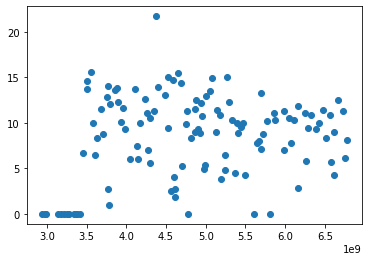

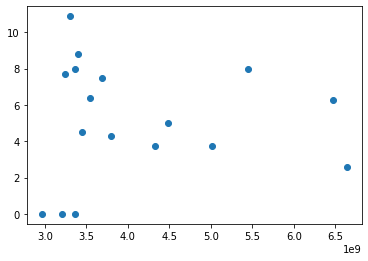

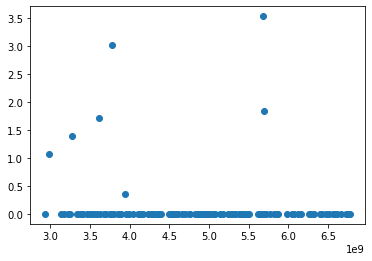

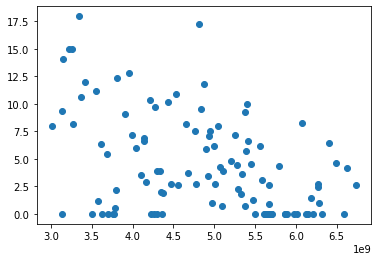

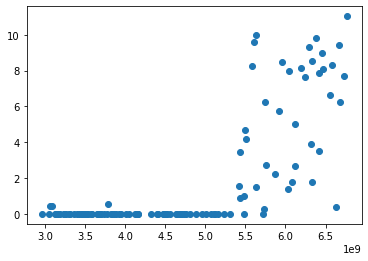

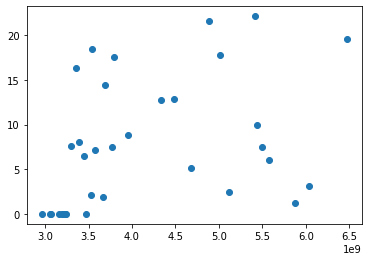

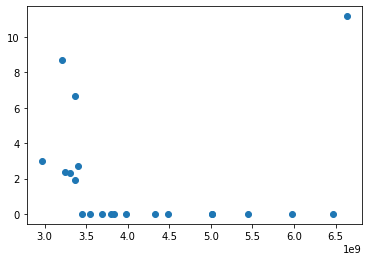

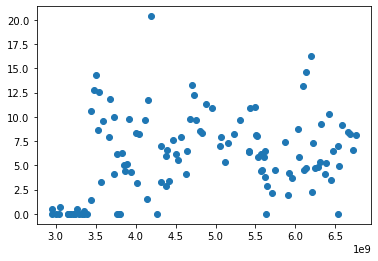

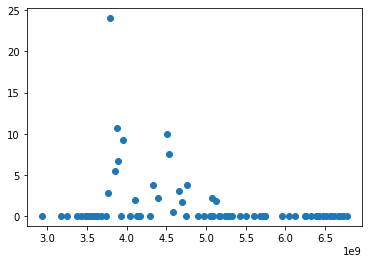

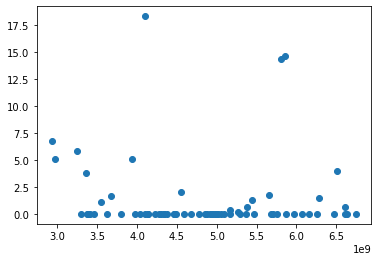

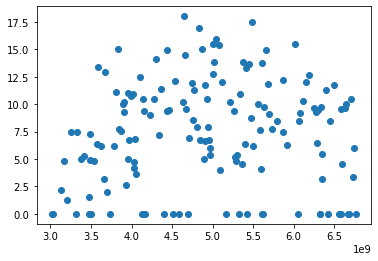

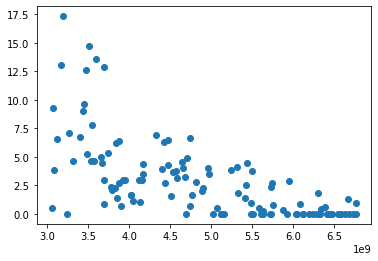

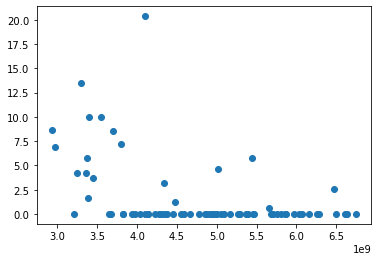

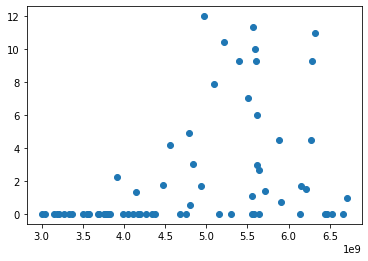

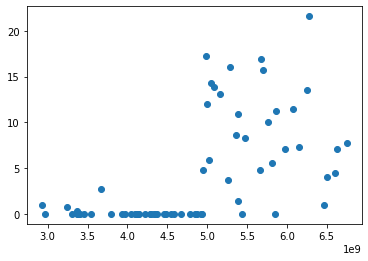

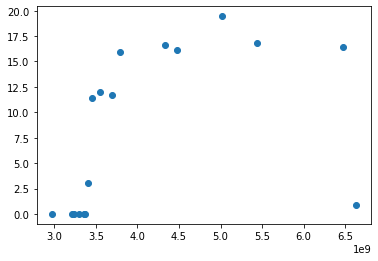

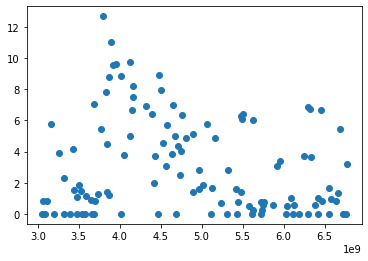

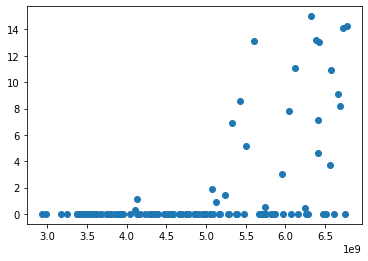

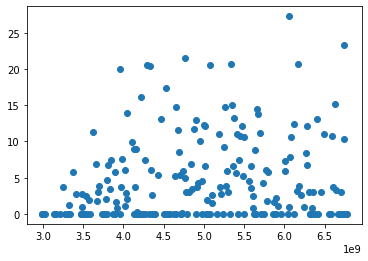

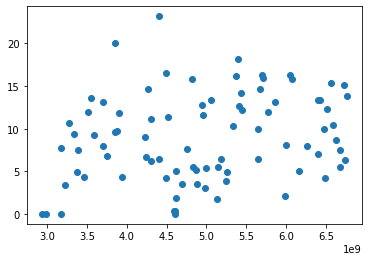

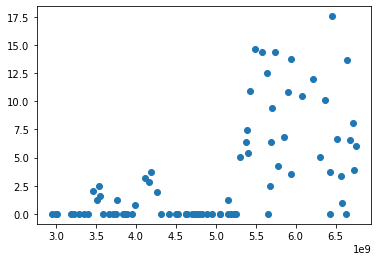

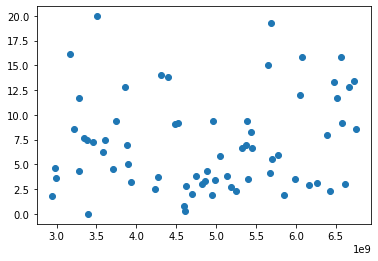

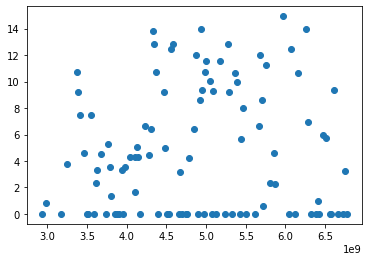

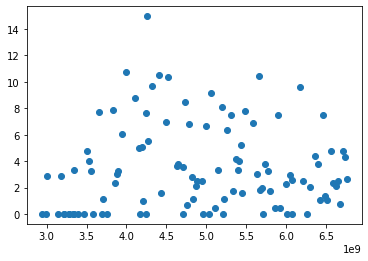

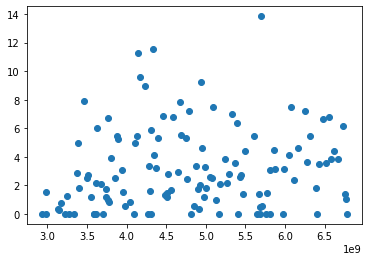

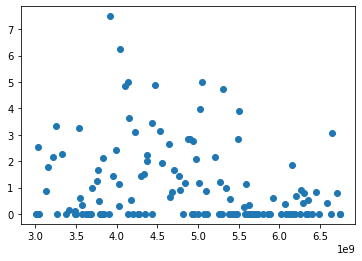

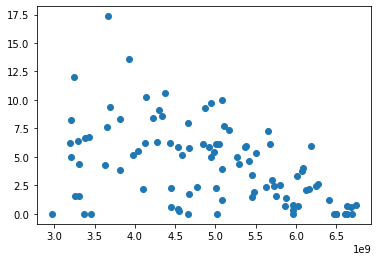

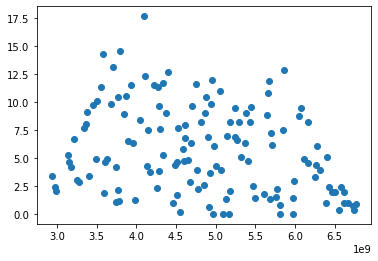

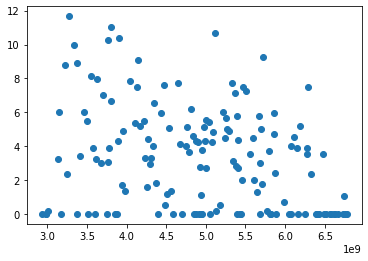

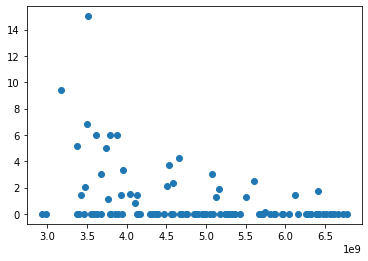

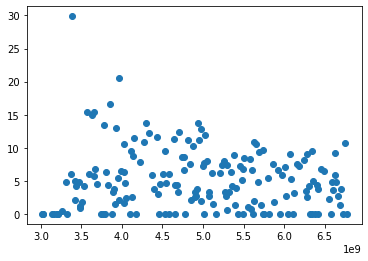

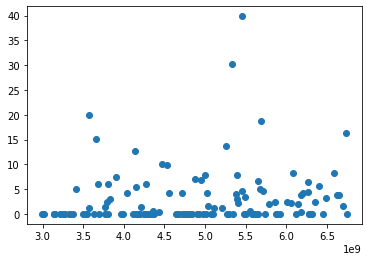

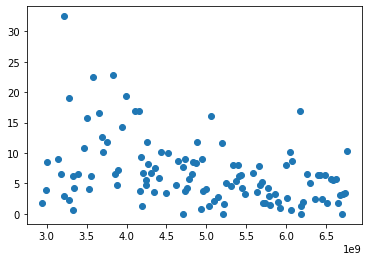

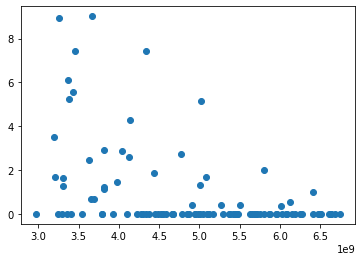

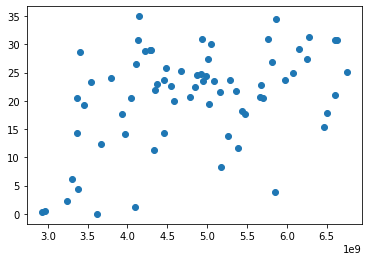

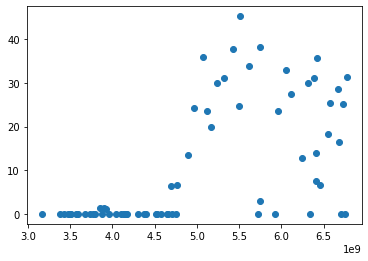

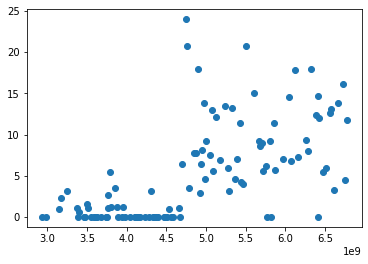

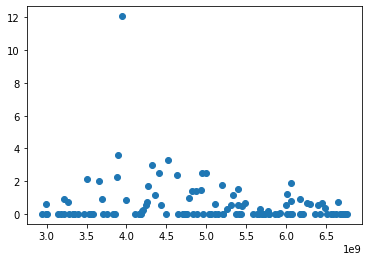

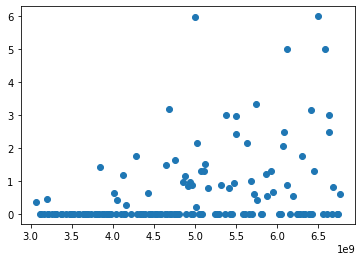

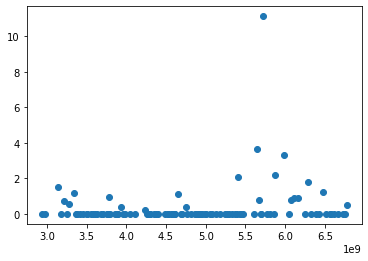

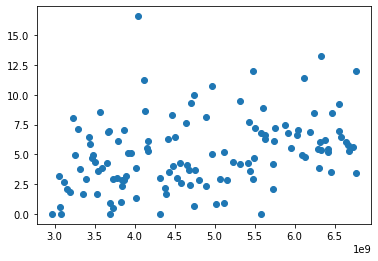

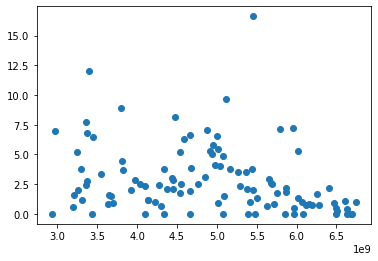

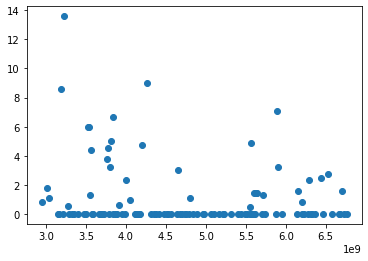

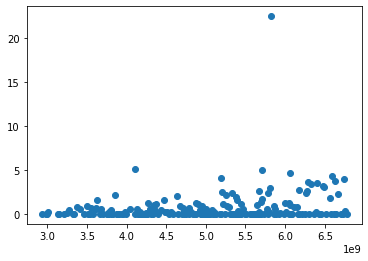

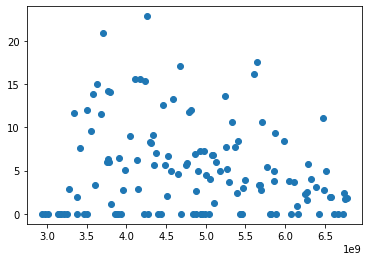

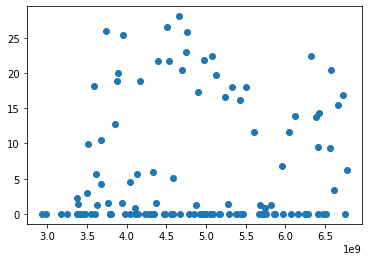

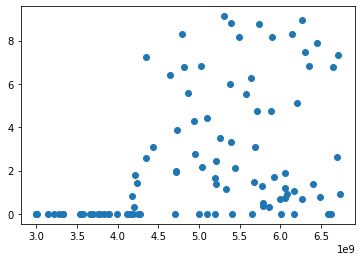

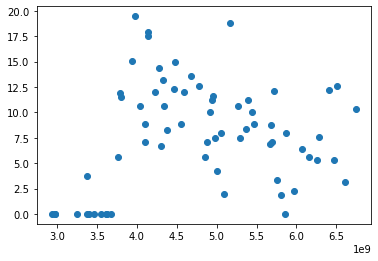

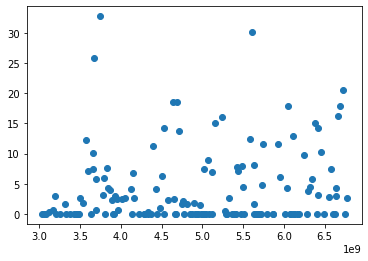

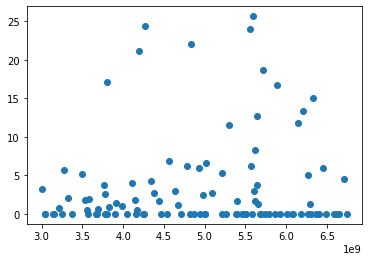

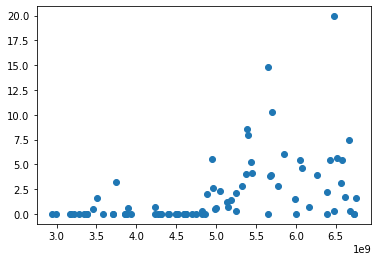

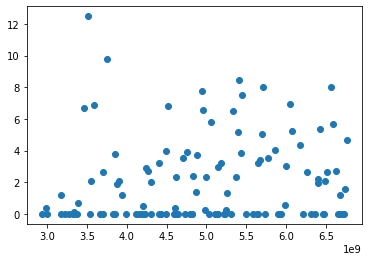

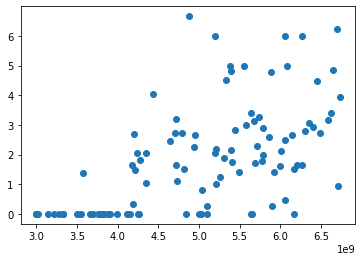

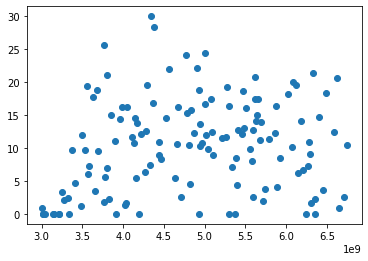

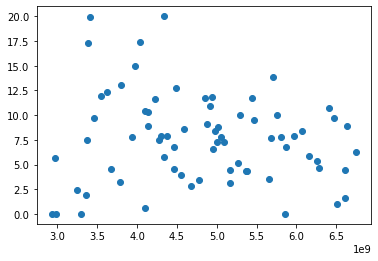

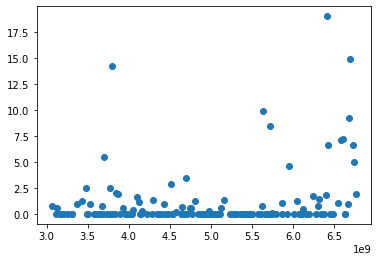

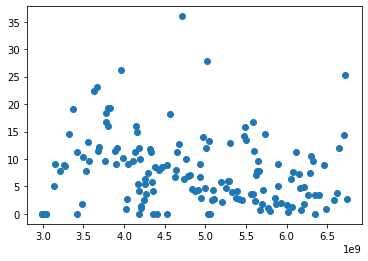

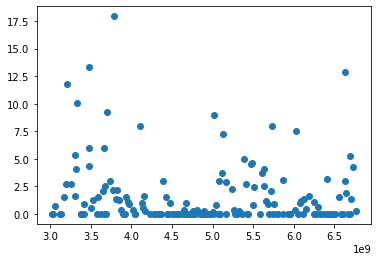

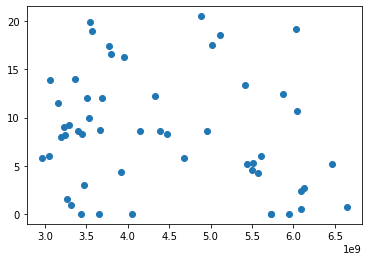

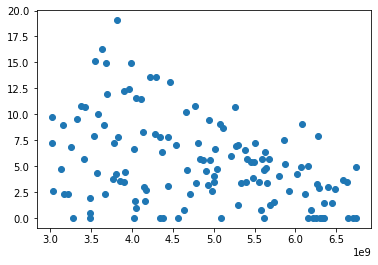

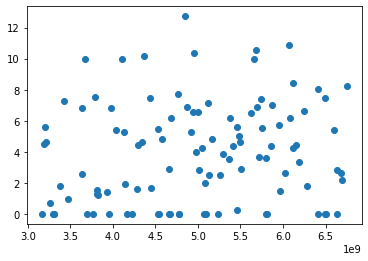

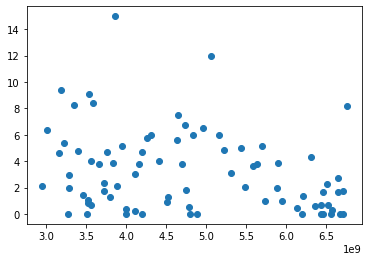

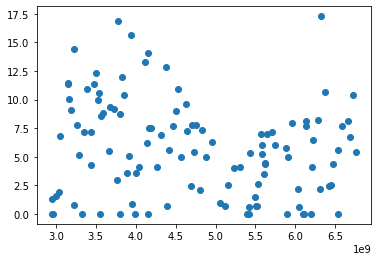

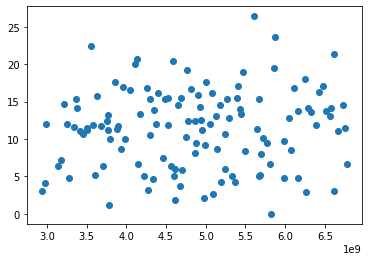

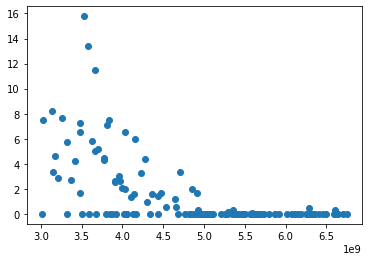

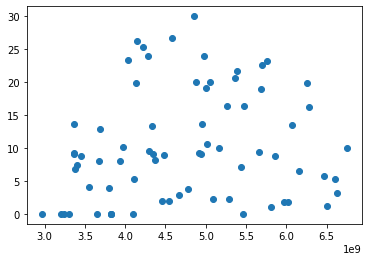

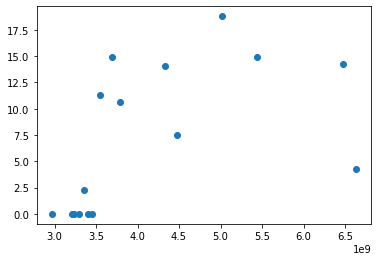

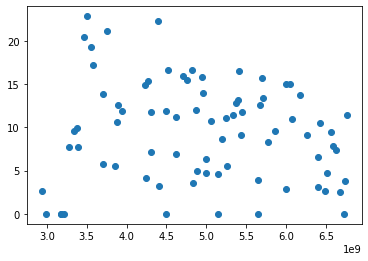

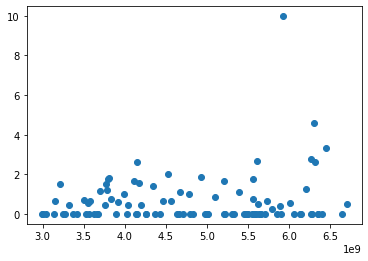

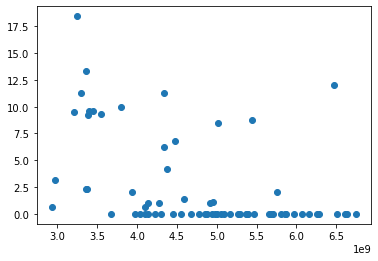

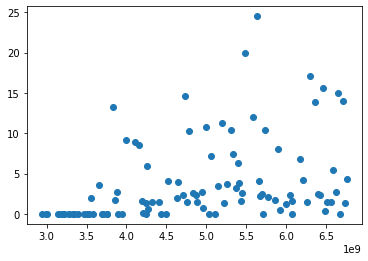

In [357]:

all_cells = alldat['R859']['D2']['units'].keys()
for each_cell in all_cells:
    data = alldat['R859']['D2']['units'][each_cell]
    for i in range(len(data.fields)):
        plt.plot(np.array(data.fields[i])[:,0], np.array(data.fields[i])[:,1],'o')
        plt.show()


In [358]:
if len(all_fields_added)>10:
    all_fields_added = np.array(all_fields_added).T
if len(all_fields_removed)>10:
    all_fields_removed = np.array(all_fields_removed).T  
if len(all_fields_present)>10:
    all_fields_present = np.array(all_fields_present).T

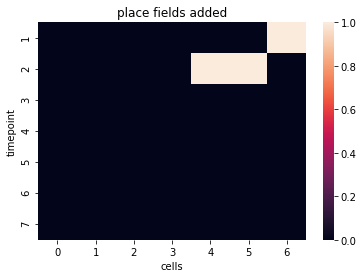

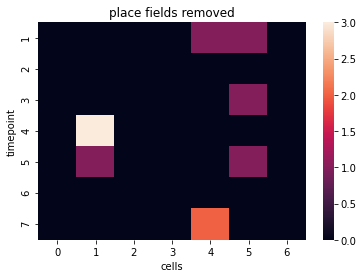

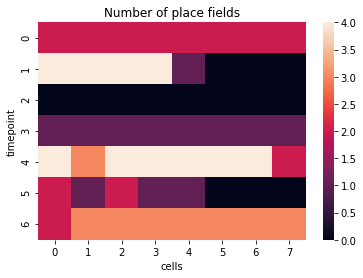

In [359]:
sb.heatmap(np.array(all_fields_added), yticklabels =np.arange(1,len(field_added)+1,1))
plt.xlabel('cells')
plt.ylabel('timepoint')
plt.title('place fields added')
plt.show()
plt.show()
sb.heatmap(np.array(all_fields_removed), yticklabels =np.arange(1,len(field_added)+1,1))
plt.xlabel('cells')
plt.ylabel('timepoint')
plt.title('place fields removed')
plt.show()
sb.heatmap(np.array(all_fields_present))
plt.xlabel('cells')
plt.ylabel('timepoint')
plt.title('Number of place fields')
plt.show()

ValueError: List of violinplot statistics and `positions` values must have the same length

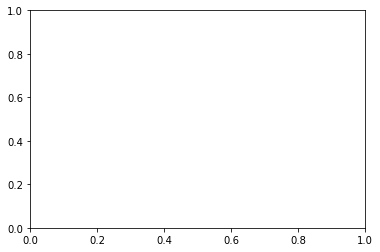

In [355]:
fig, ax = plt.subplots()
ax.violinplot(dataset=np.array(all_fields_present).T,positions=range(8))
plt.title('number of place fields for each cell')
plt.xlabel('timepoint')

In [366]:
all_fields_removed

array([], dtype=float64)

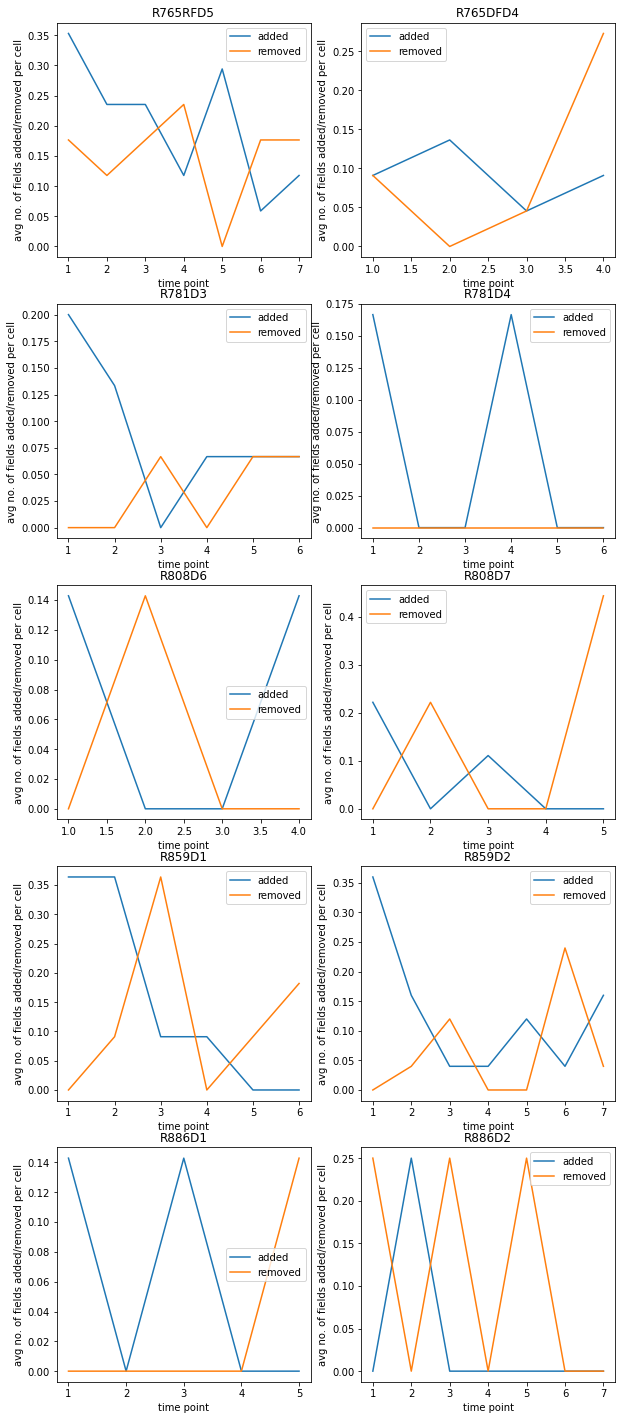

In [369]:
fig, axs = plt.subplots(5,2,figsize=(10,25))
for i in range(len(all_rats_fields_added)):
    
    all_fields_added = all_rats_fields_added[i].T
    all_fields_removed = all_rats_fields_removed[i].T
    if len(all_fields_removed)!= 0:
        axs[int(i/2), i%2].plot(np.arange(1, len(all_fields_added)+1, 1),np.mean(all_fields_added, axis = 1), label= 'added')
        axs[int(i/2), i%2].plot(np.arange(1, len(all_fields_added)+1, 1),np.mean(all_fields_removed, axis = 1), label= 'removed')
        axs[int(i/2), i%2].legend()
        axs[int(i/2), i%2].set_title(all_titles[i])
        axs[int(i/2), i%2].set_xlabel('time point')
        axs[int(i/2), i%2].set_ylabel('avg no. of fields added/removed per cell')

array([], dtype=int64)

In [91]:
a = np.array([False, True, True, False, True])
print(a[1:])
print(a[0:-1])    
## True to False removed
## False to true added
print(a[0:-1]*a[1:])
print(a[0:-1]*a[1:]*a[1:])

[ True  True False  True]
[False  True  True False]
[False  True False False]
[False  True False False]


In [51]:
i = 0
p = data.position[dt*i:(i+1)*dt,]
s = data.spikes[data.spikes[:,0] <p[-1][0]]
s = s[s[:,0]>p[0][0]]
plt.plot()

[[2.97029193e+09 1.49041200e+02 2.75623500e+02]
 [3.02066306e+09 3.18440000e+02 2.13450000e+02]
 [3.02071224e+09 3.17881200e+02 2.13435600e+02]
 [3.02071696e+09 3.17881200e+02 2.13435600e+02]
 [3.03826984e+09 4.09479200e+02 1.70048600e+02]
 [3.03863406e+09 4.12936800e+02 1.53578900e+02]
 [3.03863737e+09 4.12936800e+02 1.53578900e+02]
 [3.03864268e+09 4.12936800e+02 1.53578900e+02]
 [3.03864774e+09 4.12936800e+02 1.53578900e+02]
 [3.03901656e+09 4.16177500e+02 1.57917200e+02]
 [3.03902030e+09 4.16177500e+02 1.57917200e+02]
 [3.03930106e+09 4.07816700e+02 1.58511100e+02]
 [3.03930877e+09 4.07816700e+02 1.58511100e+02]
 [3.13599324e+09 3.53644600e+02 2.29253000e+02]
 [3.17149802e+09 3.14973000e+02 3.76832400e+02]
 [3.17150306e+09 3.14973000e+02 3.76832400e+02]
 [3.17150656e+09 3.14973000e+02 3.76832400e+02]
 [3.17151077e+09 3.14973000e+02 3.76832400e+02]
 [3.22183984e+09 5.09569200e+02 3.16225600e+02]]


In [196]:
def omega(tau):
    h = (time[1]-time[0])/2
    sig_window = 50*h##30*h
    mult = 1/(((2*np.pi)**.5)*sig_window)
    return(mult*np.exp((-tau**2)/(2*sig_window**2)))

In [219]:
len(data.spikes)

1793

In [294]:
## regression analysis with repeating and non-repeating cells separate
## to calculate firing rate

all_cells = alldat['R859']['D2']['units'].keys()
num_neurons = len(all_cells)

##data = alldat['R859']['D2']['units'][all_cells[0]]
time = np.array(data.position)[:,0]
num_times = len(time)
inst_fr = np.empty((num_neurons, num_times))
neur = 0
for each_cell in all_cells:
    print(neur)
    data = alldat['R859']['D2']['units'][each_cell]
    if data.repeating == True:
        omega_tot = np.zeros(num_times)
        for spike in range(0,len(data.spikes)):
            diff = time-data.spikes[:,0][spike]
            omega_tot = omega_tot + omega(diff)
    
        inst_fr[neur,:] = omega_tot
        neur = neur + 1
    else:
        print('not')
            
            

0
not
0
not
0
not
0
not
0
not
0
not
0
1
not
1
not
1
not
1
not
1
2
not
2
not
2
not
2
3
not
3
not
3
4
not
4
5
6
7
8
9
not
9
not
9
10
not
10
not
10
not
10
11
not
11
not
11
12
13
not
13
14
not


In [272]:
len(data.position[:,1])

84186

In [295]:
## To get firing rates within alleys and intersections only 
x = data.position[:,1]##np.load('/Users/maanasa/ratterdam/RatterdamOpen_Project/R859_D2_x_pos.npy')
y = data.position[:,2]##np.load('/Users/maanasa/ratterdam/RatterdamOpen_Project/R859_D2_y_pos.npy')
boundaries = bounds2.loadAlleyBounds('R859', 'D2')[-2]

pos_alley = []
x_new = []
y_new = []
time_within = []


num_neurons = len(inst_fr)
print(num_neurons)
print(len(inst_fr))

inst_fr_new = np.zeros(num_neurons)
for i in range(len(time)):
    print(i)
    found = False
    for j in range(0,len(bound_list)): 
        alley = bound_list[j]
        if x[i] > boundaries[alley][0][0] and x[i] <= boundaries[alley][0][1]:
            if y[i]>boundaries[alley][1][0] and y[i] <= boundaries[alley][1][1]:
                pos_alley.append(alley)
                found = True
                break
    if found == True:
        inst_fr_new = np.vstack((inst_fr_new, inst_fr[:,i]))
        x_new.append(x[i])
        y_new.append(y[i])
        time_within.append(time[i])
        ##direction_within.append(directions[i])
        
inst_fr_new = inst_fr_new[1:]   

39
39
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408


4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235


5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959
5960
5961
5962
5963
5964
5965
5966
5967
5968
5969
5970
5971
5972
5973
5974
5975
5976
5977
5978
5979
5980
5981
5982
5983
5984
5985
5986
5987
5988
5989
5990
5991
5992
5993
5994


7463
7464
7465
7466
7467
7468
7469
7470
7471
7472
7473
7474
7475
7476
7477
7478
7479
7480
7481
7482
7483
7484
7485
7486
7487
7488
7489
7490
7491
7492
7493
7494
7495
7496
7497
7498
7499
7500
7501
7502
7503
7504
7505
7506
7507
7508
7509
7510
7511
7512
7513
7514
7515
7516
7517
7518
7519
7520
7521
7522
7523
7524
7525
7526
7527
7528
7529
7530
7531
7532
7533
7534
7535
7536
7537
7538
7539
7540
7541
7542
7543
7544
7545
7546
7547
7548
7549
7550
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
7609
7610
7611
7612
7613
7614
7615
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662


9306
9307
9308
9309
9310
9311
9312
9313
9314
9315
9316
9317
9318
9319
9320
9321
9322
9323
9324
9325
9326
9327
9328
9329
9330
9331
9332
9333
9334
9335
9336
9337
9338
9339
9340
9341
9342
9343
9344
9345
9346
9347
9348
9349
9350
9351
9352
9353
9354
9355
9356
9357
9358
9359
9360
9361
9362
9363
9364
9365
9366
9367
9368
9369
9370
9371
9372
9373
9374
9375
9376
9377
9378
9379
9380
9381
9382
9383
9384
9385
9386
9387
9388
9389
9390
9391
9392
9393
9394
9395
9396
9397
9398
9399
9400
9401
9402
9403
9404
9405
9406
9407
9408
9409
9410
9411
9412
9413
9414
9415
9416
9417
9418
9419
9420
9421
9422
9423
9424
9425
9426
9427
9428
9429
9430
9431
9432
9433
9434
9435
9436
9437
9438
9439
9440
9441
9442
9443
9444
9445
9446
9447
9448
9449
9450
9451
9452
9453
9454
9455
9456
9457
9458
9459
9460
9461
9462
9463
9464
9465
9466
9467
9468
9469
9470
9471
9472
9473
9474
9475
9476
9477
9478
9479
9480
9481
9482
9483
9484
9485
9486
9487
9488
9489
9490
9491
9492
9493
9494
9495
9496
9497
9498
9499
9500
9501
9502
9503
9504
9505


10903
10904
10905
10906
10907
10908
10909
10910
10911
10912
10913
10914
10915
10916
10917
10918
10919
10920
10921
10922
10923
10924
10925
10926
10927
10928
10929
10930
10931
10932
10933
10934
10935
10936
10937
10938
10939
10940
10941
10942
10943
10944
10945
10946
10947
10948
10949
10950
10951
10952
10953
10954
10955
10956
10957
10958
10959
10960
10961
10962
10963
10964
10965
10966
10967
10968
10969
10970
10971
10972
10973
10974
10975
10976
10977
10978
10979
10980
10981
10982
10983
10984
10985
10986
10987
10988
10989
10990
10991
10992
10993
10994
10995
10996
10997
10998
10999
11000
11001
11002
11003
11004
11005
11006
11007
11008
11009
11010
11011
11012
11013
11014
11015
11016
11017
11018
11019
11020
11021
11022
11023
11024
11025
11026
11027
11028
11029
11030
11031
11032
11033
11034
11035
11036
11037
11038
11039
11040
11041
11042
11043
11044
11045
11046
11047
11048
11049
11050
11051
11052
11053
11054
11055
11056
11057
11058
11059
11060
11061
11062
11063
11064
11065
11066
11067
11068
1106

12304
12305
12306
12307
12308
12309
12310
12311
12312
12313
12314
12315
12316
12317
12318
12319
12320
12321
12322
12323
12324
12325
12326
12327
12328
12329
12330
12331
12332
12333
12334
12335
12336
12337
12338
12339
12340
12341
12342
12343
12344
12345
12346
12347
12348
12349
12350
12351
12352
12353
12354
12355
12356
12357
12358
12359
12360
12361
12362
12363
12364
12365
12366
12367
12368
12369
12370
12371
12372
12373
12374
12375
12376
12377
12378
12379
12380
12381
12382
12383
12384
12385
12386
12387
12388
12389
12390
12391
12392
12393
12394
12395
12396
12397
12398
12399
12400
12401
12402
12403
12404
12405
12406
12407
12408
12409
12410
12411
12412
12413
12414
12415
12416
12417
12418
12419
12420
12421
12422
12423
12424
12425
12426
12427
12428
12429
12430
12431
12432
12433
12434
12435
12436
12437
12438
12439
12440
12441
12442
12443
12444
12445
12446
12447
12448
12449
12450
12451
12452
12453
12454
12455
12456
12457
12458
12459
12460
12461
12462
12463
12464
12465
12466
12467
12468
12469
1247

13756
13757
13758
13759
13760
13761
13762
13763
13764
13765
13766
13767
13768
13769
13770
13771
13772
13773
13774
13775
13776
13777
13778
13779
13780
13781
13782
13783
13784
13785
13786
13787
13788
13789
13790
13791
13792
13793
13794
13795
13796
13797
13798
13799
13800
13801
13802
13803
13804
13805
13806
13807
13808
13809
13810
13811
13812
13813
13814
13815
13816
13817
13818
13819
13820
13821
13822
13823
13824
13825
13826
13827
13828
13829
13830
13831
13832
13833
13834
13835
13836
13837
13838
13839
13840
13841
13842
13843
13844
13845
13846
13847
13848
13849
13850
13851
13852
13853
13854
13855
13856
13857
13858
13859
13860
13861
13862
13863
13864
13865
13866
13867
13868
13869
13870
13871
13872
13873
13874
13875
13876
13877
13878
13879
13880
13881
13882
13883
13884
13885
13886
13887
13888
13889
13890
13891
13892
13893
13894
13895
13896
13897
13898
13899
13900
13901
13902
13903
13904
13905
13906
13907
13908
13909
13910
13911
13912
13913
13914
13915
13916
13917
13918
13919
13920
13921
1392

15236
15237
15238
15239
15240
15241
15242
15243
15244
15245
15246
15247
15248
15249
15250
15251
15252
15253
15254
15255
15256
15257
15258
15259
15260
15261
15262
15263
15264
15265
15266
15267
15268
15269
15270
15271
15272
15273
15274
15275
15276
15277
15278
15279
15280
15281
15282
15283
15284
15285
15286
15287
15288
15289
15290
15291
15292
15293
15294
15295
15296
15297
15298
15299
15300
15301
15302
15303
15304
15305
15306
15307
15308
15309
15310
15311
15312
15313
15314
15315
15316
15317
15318
15319
15320
15321
15322
15323
15324
15325
15326
15327
15328
15329
15330
15331
15332
15333
15334
15335
15336
15337
15338
15339
15340
15341
15342
15343
15344
15345
15346
15347
15348
15349
15350
15351
15352
15353
15354
15355
15356
15357
15358
15359
15360
15361
15362
15363
15364
15365
15366
15367
15368
15369
15370
15371
15372
15373
15374
15375
15376
15377
15378
15379
15380
15381
15382
15383
15384
15385
15386
15387
15388
15389
15390
15391
15392
15393
15394
15395
15396
15397
15398
15399
15400
15401
1540

16613
16614
16615
16616
16617
16618
16619
16620
16621
16622
16623
16624
16625
16626
16627
16628
16629
16630
16631
16632
16633
16634
16635
16636
16637
16638
16639
16640
16641
16642
16643
16644
16645
16646
16647
16648
16649
16650
16651
16652
16653
16654
16655
16656
16657
16658
16659
16660
16661
16662
16663
16664
16665
16666
16667
16668
16669
16670
16671
16672
16673
16674
16675
16676
16677
16678
16679
16680
16681
16682
16683
16684
16685
16686
16687
16688
16689
16690
16691
16692
16693
16694
16695
16696
16697
16698
16699
16700
16701
16702
16703
16704
16705
16706
16707
16708
16709
16710
16711
16712
16713
16714
16715
16716
16717
16718
16719
16720
16721
16722
16723
16724
16725
16726
16727
16728
16729
16730
16731
16732
16733
16734
16735
16736
16737
16738
16739
16740
16741
16742
16743
16744
16745
16746
16747
16748
16749
16750
16751
16752
16753
16754
16755
16756
16757
16758
16759
16760
16761
16762
16763
16764
16765
16766
16767
16768
16769
16770
16771
16772
16773
16774
16775
16776
16777
16778
1677

18077
18078
18079
18080
18081
18082
18083
18084
18085
18086
18087
18088
18089
18090
18091
18092
18093
18094
18095
18096
18097
18098
18099
18100
18101
18102
18103
18104
18105
18106
18107
18108
18109
18110
18111
18112
18113
18114
18115
18116
18117
18118
18119
18120
18121
18122
18123
18124
18125
18126
18127
18128
18129
18130
18131
18132
18133
18134
18135
18136
18137
18138
18139
18140
18141
18142
18143
18144
18145
18146
18147
18148
18149
18150
18151
18152
18153
18154
18155
18156
18157
18158
18159
18160
18161
18162
18163
18164
18165
18166
18167
18168
18169
18170
18171
18172
18173
18174
18175
18176
18177
18178
18179
18180
18181
18182
18183
18184
18185
18186
18187
18188
18189
18190
18191
18192
18193
18194
18195
18196
18197
18198
18199
18200
18201
18202
18203
18204
18205
18206
18207
18208
18209
18210
18211
18212
18213
18214
18215
18216
18217
18218
18219
18220
18221
18222
18223
18224
18225
18226
18227
18228
18229
18230
18231
18232
18233
18234
18235
18236
18237
18238
18239
18240
18241
18242
1824

19494
19495
19496
19497
19498
19499
19500
19501
19502
19503
19504
19505
19506
19507
19508
19509
19510
19511
19512
19513
19514
19515
19516
19517
19518
19519
19520
19521
19522
19523
19524
19525
19526
19527
19528
19529
19530
19531
19532
19533
19534
19535
19536
19537
19538
19539
19540
19541
19542
19543
19544
19545
19546
19547
19548
19549
19550
19551
19552
19553
19554
19555
19556
19557
19558
19559
19560
19561
19562
19563
19564
19565
19566
19567
19568
19569
19570
19571
19572
19573
19574
19575
19576
19577
19578
19579
19580
19581
19582
19583
19584
19585
19586
19587
19588
19589
19590
19591
19592
19593
19594
19595
19596
19597
19598
19599
19600
19601
19602
19603
19604
19605
19606
19607
19608
19609
19610
19611
19612
19613
19614
19615
19616
19617
19618
19619
19620
19621
19622
19623
19624
19625
19626
19627
19628
19629
19630
19631
19632
19633
19634
19635
19636
19637
19638
19639
19640
19641
19642
19643
19644
19645
19646
19647
19648
19649
19650
19651
19652
19653
19654
19655
19656
19657
19658
19659
1966

20902
20903
20904
20905
20906
20907
20908
20909
20910
20911
20912
20913
20914
20915
20916
20917
20918
20919
20920
20921
20922
20923
20924
20925
20926
20927
20928
20929
20930
20931
20932
20933
20934
20935
20936
20937
20938
20939
20940
20941
20942
20943
20944
20945
20946
20947
20948
20949
20950
20951
20952
20953
20954
20955
20956
20957
20958
20959
20960
20961
20962
20963
20964
20965
20966
20967
20968
20969
20970
20971
20972
20973
20974
20975
20976
20977
20978
20979
20980
20981
20982
20983
20984
20985
20986
20987
20988
20989
20990
20991
20992
20993
20994
20995
20996
20997
20998
20999
21000
21001
21002
21003
21004
21005
21006
21007
21008
21009
21010
21011
21012
21013
21014
21015
21016
21017
21018
21019
21020
21021
21022
21023
21024
21025
21026
21027
21028
21029
21030
21031
21032
21033
21034
21035
21036
21037
21038
21039
21040
21041
21042
21043
21044
21045
21046
21047
21048
21049
21050
21051
21052
21053
21054
21055
21056
21057
21058
21059
21060
21061
21062
21063
21064
21065
21066
21067
2106

22309
22310
22311
22312
22313
22314
22315
22316
22317
22318
22319
22320
22321
22322
22323
22324
22325
22326
22327
22328
22329
22330
22331
22332
22333
22334
22335
22336
22337
22338
22339
22340
22341
22342
22343
22344
22345
22346
22347
22348
22349
22350
22351
22352
22353
22354
22355
22356
22357
22358
22359
22360
22361
22362
22363
22364
22365
22366
22367
22368
22369
22370
22371
22372
22373
22374
22375
22376
22377
22378
22379
22380
22381
22382
22383
22384
22385
22386
22387
22388
22389
22390
22391
22392
22393
22394
22395
22396
22397
22398
22399
22400
22401
22402
22403
22404
22405
22406
22407
22408
22409
22410
22411
22412
22413
22414
22415
22416
22417
22418
22419
22420
22421
22422
22423
22424
22425
22426
22427
22428
22429
22430
22431
22432
22433
22434
22435
22436
22437
22438
22439
22440
22441
22442
22443
22444
22445
22446
22447
22448
22449
22450
22451
22452
22453
22454
22455
22456
22457
22458
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468
22469
22470
22471
22472
22473
22474
2247

23698
23699
23700
23701
23702
23703
23704
23705
23706
23707
23708
23709
23710
23711
23712
23713
23714
23715
23716
23717
23718
23719
23720
23721
23722
23723
23724
23725
23726
23727
23728
23729
23730
23731
23732
23733
23734
23735
23736
23737
23738
23739
23740
23741
23742
23743
23744
23745
23746
23747
23748
23749
23750
23751
23752
23753
23754
23755
23756
23757
23758
23759
23760
23761
23762
23763
23764
23765
23766
23767
23768
23769
23770
23771
23772
23773
23774
23775
23776
23777
23778
23779
23780
23781
23782
23783
23784
23785
23786
23787
23788
23789
23790
23791
23792
23793
23794
23795
23796
23797
23798
23799
23800
23801
23802
23803
23804
23805
23806
23807
23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818
23819
23820
23821
23822
23823
23824
23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847
23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
2386

25107
25108
25109
25110
25111
25112
25113
25114
25115
25116
25117
25118
25119
25120
25121
25122
25123
25124
25125
25126
25127
25128
25129
25130
25131
25132
25133
25134
25135
25136
25137
25138
25139
25140
25141
25142
25143
25144
25145
25146
25147
25148
25149
25150
25151
25152
25153
25154
25155
25156
25157
25158
25159
25160
25161
25162
25163
25164
25165
25166
25167
25168
25169
25170
25171
25172
25173
25174
25175
25176
25177
25178
25179
25180
25181
25182
25183
25184
25185
25186
25187
25188
25189
25190
25191
25192
25193
25194
25195
25196
25197
25198
25199
25200
25201
25202
25203
25204
25205
25206
25207
25208
25209
25210
25211
25212
25213
25214
25215
25216
25217
25218
25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
2527

26509
26510
26511
26512
26513
26514
26515
26516
26517
26518
26519
26520
26521
26522
26523
26524
26525
26526
26527
26528
26529
26530
26531
26532
26533
26534
26535
26536
26537
26538
26539
26540
26541
26542
26543
26544
26545
26546
26547
26548
26549
26550
26551
26552
26553
26554
26555
26556
26557
26558
26559
26560
26561
26562
26563
26564
26565
26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576
26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
2667

27899
27900
27901
27902
27903
27904
27905
27906
27907
27908
27909
27910
27911
27912
27913
27914
27915
27916
27917
27918
27919
27920
27921
27922
27923
27924
27925
27926
27927
27928
27929
27930
27931
27932
27933
27934
27935
27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946
27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959
27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
27979
27980
27981
27982
27983
27984
27985
27986
27987
27988
27989
27990
27991
27992
27993
27994
27995
27996
27997
27998
27999
28000
28001
28002
28003
28004
28005
28006
28007
28008
28009
28010
28011
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029
28030
28031
28032
28033
28034
28035
28036
28037
28038
28039
28040
28041
28042
28043
28044
28045
28046
28047
28048
28049
28050
28051
28052
28053
28054
28055
28056
28057
28058
28059
28060
28061
28062
28063
28064
2806

29350
29351
29352
29353
29354
29355
29356
29357
29358
29359
29360
29361
29362
29363
29364
29365
29366
29367
29368
29369
29370
29371
29372
29373
29374
29375
29376
29377
29378
29379
29380
29381
29382
29383
29384
29385
29386
29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
29437
29438
29439
29440
29441
29442
29443
29444
29445
29446
29447
29448
29449
29450
29451
29452
29453
29454
29455
29456
29457
29458
29459
29460
29461
29462
29463
29464
29465
29466
29467
29468
29469
29470
29471
29472
29473
29474
29475
29476
29477
29478
29479
29480
29481
29482
29483
29484
29485
29486
29487
29488
29489
29490
29491
29492
29493
29494
29495
29496
29497
29498
29499
29500
29501
29502
29503
29504
29505
29506
29507
29508
29509
29510
29511
29512
29513
29514
29515
2951

30738
30739
30740
30741
30742
30743
30744
30745
30746
30747
30748
30749
30750
30751
30752
30753
30754
30755
30756
30757
30758
30759
30760
30761
30762
30763
30764
30765
30766
30767
30768
30769
30770
30771
30772
30773
30774
30775
30776
30777
30778
30779
30780
30781
30782
30783
30784
30785
30786
30787
30788
30789
30790
30791
30792
30793
30794
30795
30796
30797
30798
30799
30800
30801
30802
30803
30804
30805
30806
30807
30808
30809
30810
30811
30812
30813
30814
30815
30816
30817
30818
30819
30820
30821
30822
30823
30824
30825
30826
30827
30828
30829
30830
30831
30832
30833
30834
30835
30836
30837
30838
30839
30840
30841
30842
30843
30844
30845
30846
30847
30848
30849
30850
30851
30852
30853
30854
30855
30856
30857
30858
30859
30860
30861
30862
30863
30864
30865
30866
30867
30868
30869
30870
30871
30872
30873
30874
30875
30876
30877
30878
30879
30880
30881
30882
30883
30884
30885
30886
30887
30888
30889
30890
30891
30892
30893
30894
30895
30896
30897
30898
30899
30900
30901
30902
30903
3090

32158
32159
32160
32161
32162
32163
32164
32165
32166
32167
32168
32169
32170
32171
32172
32173
32174
32175
32176
32177
32178
32179
32180
32181
32182
32183
32184
32185
32186
32187
32188
32189
32190
32191
32192
32193
32194
32195
32196
32197
32198
32199
32200
32201
32202
32203
32204
32205
32206
32207
32208
32209
32210
32211
32212
32213
32214
32215
32216
32217
32218
32219
32220
32221
32222
32223
32224
32225
32226
32227
32228
32229
32230
32231
32232
32233
32234
32235
32236
32237
32238
32239
32240
32241
32242
32243
32244
32245
32246
32247
32248
32249
32250
32251
32252
32253
32254
32255
32256
32257
32258
32259
32260
32261
32262
32263
32264
32265
32266
32267
32268
32269
32270
32271
32272
32273
32274
32275
32276
32277
32278
32279
32280
32281
32282
32283
32284
32285
32286
32287
32288
32289
32290
32291
32292
32293
32294
32295
32296
32297
32298
32299
32300
32301
32302
32303
32304
32305
32306
32307
32308
32309
32310
32311
32312
32313
32314
32315
32316
32317
32318
32319
32320
32321
32322
32323
3232

33539
33540
33541
33542
33543
33544
33545
33546
33547
33548
33549
33550
33551
33552
33553
33554
33555
33556
33557
33558
33559
33560
33561
33562
33563
33564
33565
33566
33567
33568
33569
33570
33571
33572
33573
33574
33575
33576
33577
33578
33579
33580
33581
33582
33583
33584
33585
33586
33587
33588
33589
33590
33591
33592
33593
33594
33595
33596
33597
33598
33599
33600
33601
33602
33603
33604
33605
33606
33607
33608
33609
33610
33611
33612
33613
33614
33615
33616
33617
33618
33619
33620
33621
33622
33623
33624
33625
33626
33627
33628
33629
33630
33631
33632
33633
33634
33635
33636
33637
33638
33639
33640
33641
33642
33643
33644
33645
33646
33647
33648
33649
33650
33651
33652
33653
33654
33655
33656
33657
33658
33659
33660
33661
33662
33663
33664
33665
33666
33667
33668
33669
33670
33671
33672
33673
33674
33675
33676
33677
33678
33679
33680
33681
33682
33683
33684
33685
33686
33687
33688
33689
33690
33691
33692
33693
33694
33695
33696
33697
33698
33699
33700
33701
33702
33703
33704
3370

34917
34918
34919
34920
34921
34922
34923
34924
34925
34926
34927
34928
34929
34930
34931
34932
34933
34934
34935
34936
34937
34938
34939
34940
34941
34942
34943
34944
34945
34946
34947
34948
34949
34950
34951
34952
34953
34954
34955
34956
34957
34958
34959
34960
34961
34962
34963
34964
34965
34966
34967
34968
34969
34970
34971
34972
34973
34974
34975
34976
34977
34978
34979
34980
34981
34982
34983
34984
34985
34986
34987
34988
34989
34990
34991
34992
34993
34994
34995
34996
34997
34998
34999
35000
35001
35002
35003
35004
35005
35006
35007
35008
35009
35010
35011
35012
35013
35014
35015
35016
35017
35018
35019
35020
35021
35022
35023
35024
35025
35026
35027
35028
35029
35030
35031
35032
35033
35034
35035
35036
35037
35038
35039
35040
35041
35042
35043
35044
35045
35046
35047
35048
35049
35050
35051
35052
35053
35054
35055
35056
35057
35058
35059
35060
35061
35062
35063
35064
35065
35066
35067
35068
35069
35070
35071
35072
35073
35074
35075
35076
35077
35078
35079
35080
35081
35082
3508

36312
36313
36314
36315
36316
36317
36318
36319
36320
36321
36322
36323
36324
36325
36326
36327
36328
36329
36330
36331
36332
36333
36334
36335
36336
36337
36338
36339
36340
36341
36342
36343
36344
36345
36346
36347
36348
36349
36350
36351
36352
36353
36354
36355
36356
36357
36358
36359
36360
36361
36362
36363
36364
36365
36366
36367
36368
36369
36370
36371
36372
36373
36374
36375
36376
36377
36378
36379
36380
36381
36382
36383
36384
36385
36386
36387
36388
36389
36390
36391
36392
36393
36394
36395
36396
36397
36398
36399
36400
36401
36402
36403
36404
36405
36406
36407
36408
36409
36410
36411
36412
36413
36414
36415
36416
36417
36418
36419
36420
36421
36422
36423
36424
36425
36426
36427
36428
36429
36430
36431
36432
36433
36434
36435
36436
36437
36438
36439
36440
36441
36442
36443
36444
36445
36446
36447
36448
36449
36450
36451
36452
36453
36454
36455
36456
36457
36458
36459
36460
36461
36462
36463
36464
36465
36466
36467
36468
36469
36470
36471
36472
36473
36474
36475
36476
36477
3647

37697
37698
37699
37700
37701
37702
37703
37704
37705
37706
37707
37708
37709
37710
37711
37712
37713
37714
37715
37716
37717
37718
37719
37720
37721
37722
37723
37724
37725
37726
37727
37728
37729
37730
37731
37732
37733
37734
37735
37736
37737
37738
37739
37740
37741
37742
37743
37744
37745
37746
37747
37748
37749
37750
37751
37752
37753
37754
37755
37756
37757
37758
37759
37760
37761
37762
37763
37764
37765
37766
37767
37768
37769
37770
37771
37772
37773
37774
37775
37776
37777
37778
37779
37780
37781
37782
37783
37784
37785
37786
37787
37788
37789
37790
37791
37792
37793
37794
37795
37796
37797
37798
37799
37800
37801
37802
37803
37804
37805
37806
37807
37808
37809
37810
37811
37812
37813
37814
37815
37816
37817
37818
37819
37820
37821
37822
37823
37824
37825
37826
37827
37828
37829
37830
37831
37832
37833
37834
37835
37836
37837
37838
37839
37840
37841
37842
37843
37844
37845
37846
37847
37848
37849
37850
37851
37852
37853
37854
37855
37856
37857
37858
37859
37860
37861
37862
3786

39076
39077
39078
39079
39080
39081
39082
39083
39084
39085
39086
39087
39088
39089
39090
39091
39092
39093
39094
39095
39096
39097
39098
39099
39100
39101
39102
39103
39104
39105
39106
39107
39108
39109
39110
39111
39112
39113
39114
39115
39116
39117
39118
39119
39120
39121
39122
39123
39124
39125
39126
39127
39128
39129
39130
39131
39132
39133
39134
39135
39136
39137
39138
39139
39140
39141
39142
39143
39144
39145
39146
39147
39148
39149
39150
39151
39152
39153
39154
39155
39156
39157
39158
39159
39160
39161
39162
39163
39164
39165
39166
39167
39168
39169
39170
39171
39172
39173
39174
39175
39176
39177
39178
39179
39180
39181
39182
39183
39184
39185
39186
39187
39188
39189
39190
39191
39192
39193
39194
39195
39196
39197
39198
39199
39200
39201
39202
39203
39204
39205
39206
39207
39208
39209
39210
39211
39212
39213
39214
39215
39216
39217
39218
39219
39220
39221
39222
39223
39224
39225
39226
39227
39228
39229
39230
39231
39232
39233
39234
39235
39236
39237
39238
39239
39240
39241
3924

40475
40476
40477
40478
40479
40480
40481
40482
40483
40484
40485
40486
40487
40488
40489
40490
40491
40492
40493
40494
40495
40496
40497
40498
40499
40500
40501
40502
40503
40504
40505
40506
40507
40508
40509
40510
40511
40512
40513
40514
40515
40516
40517
40518
40519
40520
40521
40522
40523
40524
40525
40526
40527
40528
40529
40530
40531
40532
40533
40534
40535
40536
40537
40538
40539
40540
40541
40542
40543
40544
40545
40546
40547
40548
40549
40550
40551
40552
40553
40554
40555
40556
40557
40558
40559
40560
40561
40562
40563
40564
40565
40566
40567
40568
40569
40570
40571
40572
40573
40574
40575
40576
40577
40578
40579
40580
40581
40582
40583
40584
40585
40586
40587
40588
40589
40590
40591
40592
40593
40594
40595
40596
40597
40598
40599
40600
40601
40602
40603
40604
40605
40606
40607
40608
40609
40610
40611
40612
40613
40614
40615
40616
40617
40618
40619
40620
40621
40622
40623
40624
40625
40626
40627
40628
40629
40630
40631
40632
40633
40634
40635
40636
40637
40638
40639
40640
4064

41876
41877
41878
41879
41880
41881
41882
41883
41884
41885
41886
41887
41888
41889
41890
41891
41892
41893
41894
41895
41896
41897
41898
41899
41900
41901
41902
41903
41904
41905
41906
41907
41908
41909
41910
41911
41912
41913
41914
41915
41916
41917
41918
41919
41920
41921
41922
41923
41924
41925
41926
41927
41928
41929
41930
41931
41932
41933
41934
41935
41936
41937
41938
41939
41940
41941
41942
41943
41944
41945
41946
41947
41948
41949
41950
41951
41952
41953
41954
41955
41956
41957
41958
41959
41960
41961
41962
41963
41964
41965
41966
41967
41968
41969
41970
41971
41972
41973
41974
41975
41976
41977
41978
41979
41980
41981
41982
41983
41984
41985
41986
41987
41988
41989
41990
41991
41992
41993
41994
41995
41996
41997
41998
41999
42000
42001
42002
42003
42004
42005
42006
42007
42008
42009
42010
42011
42012
42013
42014
42015
42016
42017
42018
42019
42020
42021
42022
42023
42024
42025
42026
42027
42028
42029
42030
42031
42032
42033
42034
42035
42036
42037
42038
42039
42040
42041
4204

43256
43257
43258
43259
43260
43261
43262
43263
43264
43265
43266
43267
43268
43269
43270
43271
43272
43273
43274
43275
43276
43277
43278
43279
43280
43281
43282
43283
43284
43285
43286
43287
43288
43289
43290
43291
43292
43293
43294
43295
43296
43297
43298
43299
43300
43301
43302
43303
43304
43305
43306
43307
43308
43309
43310
43311
43312
43313
43314
43315
43316
43317
43318
43319
43320
43321
43322
43323
43324
43325
43326
43327
43328
43329
43330
43331
43332
43333
43334
43335
43336
43337
43338
43339
43340
43341
43342
43343
43344
43345
43346
43347
43348
43349
43350
43351
43352
43353
43354
43355
43356
43357
43358
43359
43360
43361
43362
43363
43364
43365
43366
43367
43368
43369
43370
43371
43372
43373
43374
43375
43376
43377
43378
43379
43380
43381
43382
43383
43384
43385
43386
43387
43388
43389
43390
43391
43392
43393
43394
43395
43396
43397
43398
43399
43400
43401
43402
43403
43404
43405
43406
43407
43408
43409
43410
43411
43412
43413
43414
43415
43416
43417
43418
43419
43420
43421
4342

44626
44627
44628
44629
44630
44631
44632
44633
44634
44635
44636
44637
44638
44639
44640
44641
44642
44643
44644
44645
44646
44647
44648
44649
44650
44651
44652
44653
44654
44655
44656
44657
44658
44659
44660
44661
44662
44663
44664
44665
44666
44667
44668
44669
44670
44671
44672
44673
44674
44675
44676
44677
44678
44679
44680
44681
44682
44683
44684
44685
44686
44687
44688
44689
44690
44691
44692
44693
44694
44695
44696
44697
44698
44699
44700
44701
44702
44703
44704
44705
44706
44707
44708
44709
44710
44711
44712
44713
44714
44715
44716
44717
44718
44719
44720
44721
44722
44723
44724
44725
44726
44727
44728
44729
44730
44731
44732
44733
44734
44735
44736
44737
44738
44739
44740
44741
44742
44743
44744
44745
44746
44747
44748
44749
44750
44751
44752
44753
44754
44755
44756
44757
44758
44759
44760
44761
44762
44763
44764
44765
44766
44767
44768
44769
44770
44771
44772
44773
44774
44775
44776
44777
44778
44779
44780
44781
44782
44783
44784
44785
44786
44787
44788
44789
44790
44791
4479

45993
45994
45995
45996
45997
45998
45999
46000
46001
46002
46003
46004
46005
46006
46007
46008
46009
46010
46011
46012
46013
46014
46015
46016
46017
46018
46019
46020
46021
46022
46023
46024
46025
46026
46027
46028
46029
46030
46031
46032
46033
46034
46035
46036
46037
46038
46039
46040
46041
46042
46043
46044
46045
46046
46047
46048
46049
46050
46051
46052
46053
46054
46055
46056
46057
46058
46059
46060
46061
46062
46063
46064
46065
46066
46067
46068
46069
46070
46071
46072
46073
46074
46075
46076
46077
46078
46079
46080
46081
46082
46083
46084
46085
46086
46087
46088
46089
46090
46091
46092
46093
46094
46095
46096
46097
46098
46099
46100
46101
46102
46103
46104
46105
46106
46107
46108
46109
46110
46111
46112
46113
46114
46115
46116
46117
46118
46119
46120
46121
46122
46123
46124
46125
46126
46127
46128
46129
46130
46131
46132
46133
46134
46135
46136
46137
46138
46139
46140
46141
46142
46143
46144
46145
46146
46147
46148
46149
46150
46151
46152
46153
46154
46155
46156
46157
46158
4615

47388
47389
47390
47391
47392
47393
47394
47395
47396
47397
47398
47399
47400
47401
47402
47403
47404
47405
47406
47407
47408
47409
47410
47411
47412
47413
47414
47415
47416
47417
47418
47419
47420
47421
47422
47423
47424
47425
47426
47427
47428
47429
47430
47431
47432
47433
47434
47435
47436
47437
47438
47439
47440
47441
47442
47443
47444
47445
47446
47447
47448
47449
47450
47451
47452
47453
47454
47455
47456
47457
47458
47459
47460
47461
47462
47463
47464
47465
47466
47467
47468
47469
47470
47471
47472
47473
47474
47475
47476
47477
47478
47479
47480
47481
47482
47483
47484
47485
47486
47487
47488
47489
47490
47491
47492
47493
47494
47495
47496
47497
47498
47499
47500
47501
47502
47503
47504
47505
47506
47507
47508
47509
47510
47511
47512
47513
47514
47515
47516
47517
47518
47519
47520
47521
47522
47523
47524
47525
47526
47527
47528
47529
47530
47531
47532
47533
47534
47535
47536
47537
47538
47539
47540
47541
47542
47543
47544
47545
47546
47547
47548
47549
47550
47551
47552
47553
4755

48861
48862
48863
48864
48865
48866
48867
48868
48869
48870
48871
48872
48873
48874
48875
48876
48877
48878
48879
48880
48881
48882
48883
48884
48885
48886
48887
48888
48889
48890
48891
48892
48893
48894
48895
48896
48897
48898
48899
48900
48901
48902
48903
48904
48905
48906
48907
48908
48909
48910
48911
48912
48913
48914
48915
48916
48917
48918
48919
48920
48921
48922
48923
48924
48925
48926
48927
48928
48929
48930
48931
48932
48933
48934
48935
48936
48937
48938
48939
48940
48941
48942
48943
48944
48945
48946
48947
48948
48949
48950
48951
48952
48953
48954
48955
48956
48957
48958
48959
48960
48961
48962
48963
48964
48965
48966
48967
48968
48969
48970
48971
48972
48973
48974
48975
48976
48977
48978
48979
48980
48981
48982
48983
48984
48985
48986
48987
48988
48989
48990
48991
48992
48993
48994
48995
48996
48997
48998
48999
49000
49001
49002
49003
49004
49005
49006
49007
49008
49009
49010
49011
49012
49013
49014
49015
49016
49017
49018
49019
49020
49021
49022
49023
49024
49025
49026
4902

50249
50250
50251
50252
50253
50254
50255
50256
50257
50258
50259
50260
50261
50262
50263
50264
50265
50266
50267
50268
50269
50270
50271
50272
50273
50274
50275
50276
50277
50278
50279
50280
50281
50282
50283
50284
50285
50286
50287
50288
50289
50290
50291
50292
50293
50294
50295
50296
50297
50298
50299
50300
50301
50302
50303
50304
50305
50306
50307
50308
50309
50310
50311
50312
50313
50314
50315
50316
50317
50318
50319
50320
50321
50322
50323
50324
50325
50326
50327
50328
50329
50330
50331
50332
50333
50334
50335
50336
50337
50338
50339
50340
50341
50342
50343
50344
50345
50346
50347
50348
50349
50350
50351
50352
50353
50354
50355
50356
50357
50358
50359
50360
50361
50362
50363
50364
50365
50366
50367
50368
50369
50370
50371
50372
50373
50374
50375
50376
50377
50378
50379
50380
50381
50382
50383
50384
50385
50386
50387
50388
50389
50390
50391
50392
50393
50394
50395
50396
50397
50398
50399
50400
50401
50402
50403
50404
50405
50406
50407
50408
50409
50410
50411
50412
50413
50414
5041

51628
51629
51630
51631
51632
51633
51634
51635
51636
51637
51638
51639
51640
51641
51642
51643
51644
51645
51646
51647
51648
51649
51650
51651
51652
51653
51654
51655
51656
51657
51658
51659
51660
51661
51662
51663
51664
51665
51666
51667
51668
51669
51670
51671
51672
51673
51674
51675
51676
51677
51678
51679
51680
51681
51682
51683
51684
51685
51686
51687
51688
51689
51690
51691
51692
51693
51694
51695
51696
51697
51698
51699
51700
51701
51702
51703
51704
51705
51706
51707
51708
51709
51710
51711
51712
51713
51714
51715
51716
51717
51718
51719
51720
51721
51722
51723
51724
51725
51726
51727
51728
51729
51730
51731
51732
51733
51734
51735
51736
51737
51738
51739
51740
51741
51742
51743
51744
51745
51746
51747
51748
51749
51750
51751
51752
51753
51754
51755
51756
51757
51758
51759
51760
51761
51762
51763
51764
51765
51766
51767
51768
51769
51770
51771
51772
51773
51774
51775
51776
51777
51778
51779
51780
51781
51782
51783
51784
51785
51786
51787
51788
51789
51790
51791
51792
51793
5179

53014
53015
53016
53017
53018
53019
53020
53021
53022
53023
53024
53025
53026
53027
53028
53029
53030
53031
53032
53033
53034
53035
53036
53037
53038
53039
53040
53041
53042
53043
53044
53045
53046
53047
53048
53049
53050
53051
53052
53053
53054
53055
53056
53057
53058
53059
53060
53061
53062
53063
53064
53065
53066
53067
53068
53069
53070
53071
53072
53073
53074
53075
53076
53077
53078
53079
53080
53081
53082
53083
53084
53085
53086
53087
53088
53089
53090
53091
53092
53093
53094
53095
53096
53097
53098
53099
53100
53101
53102
53103
53104
53105
53106
53107
53108
53109
53110
53111
53112
53113
53114
53115
53116
53117
53118
53119
53120
53121
53122
53123
53124
53125
53126
53127
53128
53129
53130
53131
53132
53133
53134
53135
53136
53137
53138
53139
53140
53141
53142
53143
53144
53145
53146
53147
53148
53149
53150
53151
53152
53153
53154
53155
53156
53157
53158
53159
53160
53161
53162
53163
53164
53165
53166
53167
53168
53169
53170
53171
53172
53173
53174
53175
53176
53177
53178
53179
5318

54412
54413
54414
54415
54416
54417
54418
54419
54420
54421
54422
54423
54424
54425
54426
54427
54428
54429
54430
54431
54432
54433
54434
54435
54436
54437
54438
54439
54440
54441
54442
54443
54444
54445
54446
54447
54448
54449
54450
54451
54452
54453
54454
54455
54456
54457
54458
54459
54460
54461
54462
54463
54464
54465
54466
54467
54468
54469
54470
54471
54472
54473
54474
54475
54476
54477
54478
54479
54480
54481
54482
54483
54484
54485
54486
54487
54488
54489
54490
54491
54492
54493
54494
54495
54496
54497
54498
54499
54500
54501
54502
54503
54504
54505
54506
54507
54508
54509
54510
54511
54512
54513
54514
54515
54516
54517
54518
54519
54520
54521
54522
54523
54524
54525
54526
54527
54528
54529
54530
54531
54532
54533
54534
54535
54536
54537
54538
54539
54540
54541
54542
54543
54544
54545
54546
54547
54548
54549
54550
54551
54552
54553
54554
54555
54556
54557
54558
54559
54560
54561
54562
54563
54564
54565
54566
54567
54568
54569
54570
54571
54572
54573
54574
54575
54576
54577
5457

55785
55786
55787
55788
55789
55790
55791
55792
55793
55794
55795
55796
55797
55798
55799
55800
55801
55802
55803
55804
55805
55806
55807
55808
55809
55810
55811
55812
55813
55814
55815
55816
55817
55818
55819
55820
55821
55822
55823
55824
55825
55826
55827
55828
55829
55830
55831
55832
55833
55834
55835
55836
55837
55838
55839
55840
55841
55842
55843
55844
55845
55846
55847
55848
55849
55850
55851
55852
55853
55854
55855
55856
55857
55858
55859
55860
55861
55862
55863
55864
55865
55866
55867
55868
55869
55870
55871
55872
55873
55874
55875
55876
55877
55878
55879
55880
55881
55882
55883
55884
55885
55886
55887
55888
55889
55890
55891
55892
55893
55894
55895
55896
55897
55898
55899
55900
55901
55902
55903
55904
55905
55906
55907
55908
55909
55910
55911
55912
55913
55914
55915
55916
55917
55918
55919
55920
55921
55922
55923
55924
55925
55926
55927
55928
55929
55930
55931
55932
55933
55934
55935
55936
55937
55938
55939
55940
55941
55942
55943
55944
55945
55946
55947
55948
55949
55950
5595

57161
57162
57163
57164
57165
57166
57167
57168
57169
57170
57171
57172
57173
57174
57175
57176
57177
57178
57179
57180
57181
57182
57183
57184
57185
57186
57187
57188
57189
57190
57191
57192
57193
57194
57195
57196
57197
57198
57199
57200
57201
57202
57203
57204
57205
57206
57207
57208
57209
57210
57211
57212
57213
57214
57215
57216
57217
57218
57219
57220
57221
57222
57223
57224
57225
57226
57227
57228
57229
57230
57231
57232
57233
57234
57235
57236
57237
57238
57239
57240
57241
57242
57243
57244
57245
57246
57247
57248
57249
57250
57251
57252
57253
57254
57255
57256
57257
57258
57259
57260
57261
57262
57263
57264
57265
57266
57267
57268
57269
57270
57271
57272
57273
57274
57275
57276
57277
57278
57279
57280
57281
57282
57283
57284
57285
57286
57287
57288
57289
57290
57291
57292
57293
57294
57295
57296
57297
57298
57299
57300
57301
57302
57303
57304
57305
57306
57307
57308
57309
57310
57311
57312
57313
57314
57315
57316
57317
57318
57319
57320
57321
57322
57323
57324
57325
57326
5732

58545
58546
58547
58548
58549
58550
58551
58552
58553
58554
58555
58556
58557
58558
58559
58560
58561
58562
58563
58564
58565
58566
58567
58568
58569
58570
58571
58572
58573
58574
58575
58576
58577
58578
58579
58580
58581
58582
58583
58584
58585
58586
58587
58588
58589
58590
58591
58592
58593
58594
58595
58596
58597
58598
58599
58600
58601
58602
58603
58604
58605
58606
58607
58608
58609
58610
58611
58612
58613
58614
58615
58616
58617
58618
58619
58620
58621
58622
58623
58624
58625
58626
58627
58628
58629
58630
58631
58632
58633
58634
58635
58636
58637
58638
58639
58640
58641
58642
58643
58644
58645
58646
58647
58648
58649
58650
58651
58652
58653
58654
58655
58656
58657
58658
58659
58660
58661
58662
58663
58664
58665
58666
58667
58668
58669
58670
58671
58672
58673
58674
58675
58676
58677
58678
58679
58680
58681
58682
58683
58684
58685
58686
58687
58688
58689
58690
58691
58692
58693
58694
58695
58696
58697
58698
58699
58700
58701
58702
58703
58704
58705
58706
58707
58708
58709
58710
5871

59914
59915
59916
59917
59918
59919
59920
59921
59922
59923
59924
59925
59926
59927
59928
59929
59930
59931
59932
59933
59934
59935
59936
59937
59938
59939
59940
59941
59942
59943
59944
59945
59946
59947
59948
59949
59950
59951
59952
59953
59954
59955
59956
59957
59958
59959
59960
59961
59962
59963
59964
59965
59966
59967
59968
59969
59970
59971
59972
59973
59974
59975
59976
59977
59978
59979
59980
59981
59982
59983
59984
59985
59986
59987
59988
59989
59990
59991
59992
59993
59994
59995
59996
59997
59998
59999
60000
60001
60002
60003
60004
60005
60006
60007
60008
60009
60010
60011
60012
60013
60014
60015
60016
60017
60018
60019
60020
60021
60022
60023
60024
60025
60026
60027
60028
60029
60030
60031
60032
60033
60034
60035
60036
60037
60038
60039
60040
60041
60042
60043
60044
60045
60046
60047
60048
60049
60050
60051
60052
60053
60054
60055
60056
60057
60058
60059
60060
60061
60062
60063
60064
60065
60066
60067
60068
60069
60070
60071
60072
60073
60074
60075
60076
60077
60078
60079
6008

61294
61295
61296
61297
61298
61299
61300
61301
61302
61303
61304
61305
61306
61307
61308
61309
61310
61311
61312
61313
61314
61315
61316
61317
61318
61319
61320
61321
61322
61323
61324
61325
61326
61327
61328
61329
61330
61331
61332
61333
61334
61335
61336
61337
61338
61339
61340
61341
61342
61343
61344
61345
61346
61347
61348
61349
61350
61351
61352
61353
61354
61355
61356
61357
61358
61359
61360
61361
61362
61363
61364
61365
61366
61367
61368
61369
61370
61371
61372
61373
61374
61375
61376
61377
61378
61379
61380
61381
61382
61383
61384
61385
61386
61387
61388
61389
61390
61391
61392
61393
61394
61395
61396
61397
61398
61399
61400
61401
61402
61403
61404
61405
61406
61407
61408
61409
61410
61411
61412
61413
61414
61415
61416
61417
61418
61419
61420
61421
61422
61423
61424
61425
61426
61427
61428
61429
61430
61431
61432
61433
61434
61435
61436
61437
61438
61439
61440
61441
61442
61443
61444
61445
61446
61447
61448
61449
61450
61451
61452
61453
61454
61455
61456
61457
61458
61459
6146

62663
62664
62665
62666
62667
62668
62669
62670
62671
62672
62673
62674
62675
62676
62677
62678
62679
62680
62681
62682
62683
62684
62685
62686
62687
62688
62689
62690
62691
62692
62693
62694
62695
62696
62697
62698
62699
62700
62701
62702
62703
62704
62705
62706
62707
62708
62709
62710
62711
62712
62713
62714
62715
62716
62717
62718
62719
62720
62721
62722
62723
62724
62725
62726
62727
62728
62729
62730
62731
62732
62733
62734
62735
62736
62737
62738
62739
62740
62741
62742
62743
62744
62745
62746
62747
62748
62749
62750
62751
62752
62753
62754
62755
62756
62757
62758
62759
62760
62761
62762
62763
62764
62765
62766
62767
62768
62769
62770
62771
62772
62773
62774
62775
62776
62777
62778
62779
62780
62781
62782
62783
62784
62785
62786
62787
62788
62789
62790
62791
62792
62793
62794
62795
62796
62797
62798
62799
62800
62801
62802
62803
62804
62805
62806
62807
62808
62809
62810
62811
62812
62813
62814
62815
62816
62817
62818
62819
62820
62821
62822
62823
62824
62825
62826
62827
62828
6282

64047
64048
64049
64050
64051
64052
64053
64054
64055
64056
64057
64058
64059
64060
64061
64062
64063
64064
64065
64066
64067
64068
64069
64070
64071
64072
64073
64074
64075
64076
64077
64078
64079
64080
64081
64082
64083
64084
64085
64086
64087
64088
64089
64090
64091
64092
64093
64094
64095
64096
64097
64098
64099
64100
64101
64102
64103
64104
64105
64106
64107
64108
64109
64110
64111
64112
64113
64114
64115
64116
64117
64118
64119
64120
64121
64122
64123
64124
64125
64126
64127
64128
64129
64130
64131
64132
64133
64134
64135
64136
64137
64138
64139
64140
64141
64142
64143
64144
64145
64146
64147
64148
64149
64150
64151
64152
64153
64154
64155
64156
64157
64158
64159
64160
64161
64162
64163
64164
64165
64166
64167
64168
64169
64170
64171
64172
64173
64174
64175
64176
64177
64178
64179
64180
64181
64182
64183
64184
64185
64186
64187
64188
64189
64190
64191
64192
64193
64194
64195
64196
64197
64198
64199
64200
64201
64202
64203
64204
64205
64206
64207
64208
64209
64210
64211
64212
6421

65429
65430
65431
65432
65433
65434
65435
65436
65437
65438
65439
65440
65441
65442
65443
65444
65445
65446
65447
65448
65449
65450
65451
65452
65453
65454
65455
65456
65457
65458
65459
65460
65461
65462
65463
65464
65465
65466
65467
65468
65469
65470
65471
65472
65473
65474
65475
65476
65477
65478
65479
65480
65481
65482
65483
65484
65485
65486
65487
65488
65489
65490
65491
65492
65493
65494
65495
65496
65497
65498
65499
65500
65501
65502
65503
65504
65505
65506
65507
65508
65509
65510
65511
65512
65513
65514
65515
65516
65517
65518
65519
65520
65521
65522
65523
65524
65525
65526
65527
65528
65529
65530
65531
65532
65533
65534
65535
65536
65537
65538
65539
65540
65541
65542
65543
65544
65545
65546
65547
65548
65549
65550
65551
65552
65553
65554
65555
65556
65557
65558
65559
65560
65561
65562
65563
65564
65565
65566
65567
65568
65569
65570
65571
65572
65573
65574
65575
65576
65577
65578
65579
65580
65581
65582
65583
65584
65585
65586
65587
65588
65589
65590
65591
65592
65593
65594
6559

66818
66819
66820
66821
66822
66823
66824
66825
66826
66827
66828
66829
66830
66831
66832
66833
66834
66835
66836
66837
66838
66839
66840
66841
66842
66843
66844
66845
66846
66847
66848
66849
66850
66851
66852
66853
66854
66855
66856
66857
66858
66859
66860
66861
66862
66863
66864
66865
66866
66867
66868
66869
66870
66871
66872
66873
66874
66875
66876
66877
66878
66879
66880
66881
66882
66883
66884
66885
66886
66887
66888
66889
66890
66891
66892
66893
66894
66895
66896
66897
66898
66899
66900
66901
66902
66903
66904
66905
66906
66907
66908
66909
66910
66911
66912
66913
66914
66915
66916
66917
66918
66919
66920
66921
66922
66923
66924
66925
66926
66927
66928
66929
66930
66931
66932
66933
66934
66935
66936
66937
66938
66939
66940
66941
66942
66943
66944
66945
66946
66947
66948
66949
66950
66951
66952
66953
66954
66955
66956
66957
66958
66959
66960
66961
66962
66963
66964
66965
66966
66967
66968
66969
66970
66971
66972
66973
66974
66975
66976
66977
66978
66979
66980
66981
66982
66983
6698

68197
68198
68199
68200
68201
68202
68203
68204
68205
68206
68207
68208
68209
68210
68211
68212
68213
68214
68215
68216
68217
68218
68219
68220
68221
68222
68223
68224
68225
68226
68227
68228
68229
68230
68231
68232
68233
68234
68235
68236
68237
68238
68239
68240
68241
68242
68243
68244
68245
68246
68247
68248
68249
68250
68251
68252
68253
68254
68255
68256
68257
68258
68259
68260
68261
68262
68263
68264
68265
68266
68267
68268
68269
68270
68271
68272
68273
68274
68275
68276
68277
68278
68279
68280
68281
68282
68283
68284
68285
68286
68287
68288
68289
68290
68291
68292
68293
68294
68295
68296
68297
68298
68299
68300
68301
68302
68303
68304
68305
68306
68307
68308
68309
68310
68311
68312
68313
68314
68315
68316
68317
68318
68319
68320
68321
68322
68323
68324
68325
68326
68327
68328
68329
68330
68331
68332
68333
68334
68335
68336
68337
68338
68339
68340
68341
68342
68343
68344
68345
68346
68347
68348
68349
68350
68351
68352
68353
68354
68355
68356
68357
68358
68359
68360
68361
68362
6836

69584
69585
69586
69587
69588
69589
69590
69591
69592
69593
69594
69595
69596
69597
69598
69599
69600
69601
69602
69603
69604
69605
69606
69607
69608
69609
69610
69611
69612
69613
69614
69615
69616
69617
69618
69619
69620
69621
69622
69623
69624
69625
69626
69627
69628
69629
69630
69631
69632
69633
69634
69635
69636
69637
69638
69639
69640
69641
69642
69643
69644
69645
69646
69647
69648
69649
69650
69651
69652
69653
69654
69655
69656
69657
69658
69659
69660
69661
69662
69663
69664
69665
69666
69667
69668
69669
69670
69671
69672
69673
69674
69675
69676
69677
69678
69679
69680
69681
69682
69683
69684
69685
69686
69687
69688
69689
69690
69691
69692
69693
69694
69695
69696
69697
69698
69699
69700
69701
69702
69703
69704
69705
69706
69707
69708
69709
69710
69711
69712
69713
69714
69715
69716
69717
69718
69719
69720
69721
69722
69723
69724
69725
69726
69727
69728
69729
69730
69731
69732
69733
69734
69735
69736
69737
69738
69739
69740
69741
69742
69743
69744
69745
69746
69747
69748
69749
6975

70957
70958
70959
70960
70961
70962
70963
70964
70965
70966
70967
70968
70969
70970
70971
70972
70973
70974
70975
70976
70977
70978
70979
70980
70981
70982
70983
70984
70985
70986
70987
70988
70989
70990
70991
70992
70993
70994
70995
70996
70997
70998
70999
71000
71001
71002
71003
71004
71005
71006
71007
71008
71009
71010
71011
71012
71013
71014
71015
71016
71017
71018
71019
71020
71021
71022
71023
71024
71025
71026
71027
71028
71029
71030
71031
71032
71033
71034
71035
71036
71037
71038
71039
71040
71041
71042
71043
71044
71045
71046
71047
71048
71049
71050
71051
71052
71053
71054
71055
71056
71057
71058
71059
71060
71061
71062
71063
71064
71065
71066
71067
71068
71069
71070
71071
71072
71073
71074
71075
71076
71077
71078
71079
71080
71081
71082
71083
71084
71085
71086
71087
71088
71089
71090
71091
71092
71093
71094
71095
71096
71097
71098
71099
71100
71101
71102
71103
71104
71105
71106
71107
71108
71109
71110
71111
71112
71113
71114
71115
71116
71117
71118
71119
71120
71121
71122
7112

72344
72345
72346
72347
72348
72349
72350
72351
72352
72353
72354
72355
72356
72357
72358
72359
72360
72361
72362
72363
72364
72365
72366
72367
72368
72369
72370
72371
72372
72373
72374
72375
72376
72377
72378
72379
72380
72381
72382
72383
72384
72385
72386
72387
72388
72389
72390
72391
72392
72393
72394
72395
72396
72397
72398
72399
72400
72401
72402
72403
72404
72405
72406
72407
72408
72409
72410
72411
72412
72413
72414
72415
72416
72417
72418
72419
72420
72421
72422
72423
72424
72425
72426
72427
72428
72429
72430
72431
72432
72433
72434
72435
72436
72437
72438
72439
72440
72441
72442
72443
72444
72445
72446
72447
72448
72449
72450
72451
72452
72453
72454
72455
72456
72457
72458
72459
72460
72461
72462
72463
72464
72465
72466
72467
72468
72469
72470
72471
72472
72473
72474
72475
72476
72477
72478
72479
72480
72481
72482
72483
72484
72485
72486
72487
72488
72489
72490
72491
72492
72493
72494
72495
72496
72497
72498
72499
72500
72501
72502
72503
72504
72505
72506
72507
72508
72509
7251

73731
73732
73733
73734
73735
73736
73737
73738
73739
73740
73741
73742
73743
73744
73745
73746
73747
73748
73749
73750
73751
73752
73753
73754
73755
73756
73757
73758
73759
73760
73761
73762
73763
73764
73765
73766
73767
73768
73769
73770
73771
73772
73773
73774
73775
73776
73777
73778
73779
73780
73781
73782
73783
73784
73785
73786
73787
73788
73789
73790
73791
73792
73793
73794
73795
73796
73797
73798
73799
73800
73801
73802
73803
73804
73805
73806
73807
73808
73809
73810
73811
73812
73813
73814
73815
73816
73817
73818
73819
73820
73821
73822
73823
73824
73825
73826
73827
73828
73829
73830
73831
73832
73833
73834
73835
73836
73837
73838
73839
73840
73841
73842
73843
73844
73845
73846
73847
73848
73849
73850
73851
73852
73853
73854
73855
73856
73857
73858
73859
73860
73861
73862
73863
73864
73865
73866
73867
73868
73869
73870
73871
73872
73873
73874
73875
73876
73877
73878
73879
73880
73881
73882
73883
73884
73885
73886
73887
73888
73889
73890
73891
73892
73893
73894
73895
73896
7389

75106
75107
75108
75109
75110
75111
75112
75113
75114
75115
75116
75117
75118
75119
75120
75121
75122
75123
75124
75125
75126
75127
75128
75129
75130
75131
75132
75133
75134
75135
75136
75137
75138
75139
75140
75141
75142
75143
75144
75145
75146
75147
75148
75149
75150
75151
75152
75153
75154
75155
75156
75157
75158
75159
75160
75161
75162
75163
75164
75165
75166
75167
75168
75169
75170
75171
75172
75173
75174
75175
75176
75177
75178
75179
75180
75181
75182
75183
75184
75185
75186
75187
75188
75189
75190
75191
75192
75193
75194
75195
75196
75197
75198
75199
75200
75201
75202
75203
75204
75205
75206
75207
75208
75209
75210
75211
75212
75213
75214
75215
75216
75217
75218
75219
75220
75221
75222
75223
75224
75225
75226
75227
75228
75229
75230
75231
75232
75233
75234
75235
75236
75237
75238
75239
75240
75241
75242
75243
75244
75245
75246
75247
75248
75249
75250
75251
75252
75253
75254
75255
75256
75257
75258
75259
75260
75261
75262
75263
75264
75265
75266
75267
75268
75269
75270
75271
7527

76492
76493
76494
76495
76496
76497
76498
76499
76500
76501
76502
76503
76504
76505
76506
76507
76508
76509
76510
76511
76512
76513
76514
76515
76516
76517
76518
76519
76520
76521
76522
76523
76524
76525
76526
76527
76528
76529
76530
76531
76532
76533
76534
76535
76536
76537
76538
76539
76540
76541
76542
76543
76544
76545
76546
76547
76548
76549
76550
76551
76552
76553
76554
76555
76556
76557
76558
76559
76560
76561
76562
76563
76564
76565
76566
76567
76568
76569
76570
76571
76572
76573
76574
76575
76576
76577
76578
76579
76580
76581
76582
76583
76584
76585
76586
76587
76588
76589
76590
76591
76592
76593
76594
76595
76596
76597
76598
76599
76600
76601
76602
76603
76604
76605
76606
76607
76608
76609
76610
76611
76612
76613
76614
76615
76616
76617
76618
76619
76620
76621
76622
76623
76624
76625
76626
76627
76628
76629
76630
76631
76632
76633
76634
76635
76636
76637
76638
76639
76640
76641
76642
76643
76644
76645
76646
76647
76648
76649
76650
76651
76652
76653
76654
76655
76656
76657
7665

77869
77870
77871
77872
77873
77874
77875
77876
77877
77878
77879
77880
77881
77882
77883
77884
77885
77886
77887
77888
77889
77890
77891
77892
77893
77894
77895
77896
77897
77898
77899
77900
77901
77902
77903
77904
77905
77906
77907
77908
77909
77910
77911
77912
77913
77914
77915
77916
77917
77918
77919
77920
77921
77922
77923
77924
77925
77926
77927
77928
77929
77930
77931
77932
77933
77934
77935
77936
77937
77938
77939
77940
77941
77942
77943
77944
77945
77946
77947
77948
77949
77950
77951
77952
77953
77954
77955
77956
77957
77958
77959
77960
77961
77962
77963
77964
77965
77966
77967
77968
77969
77970
77971
77972
77973
77974
77975
77976
77977
77978
77979
77980
77981
77982
77983
77984
77985
77986
77987
77988
77989
77990
77991
77992
77993
77994
77995
77996
77997
77998
77999
78000
78001
78002
78003
78004
78005
78006
78007
78008
78009
78010
78011
78012
78013
78014
78015
78016
78017
78018
78019
78020
78021
78022
78023
78024
78025
78026
78027
78028
78029
78030
78031
78032
78033
78034
7803

79238
79239
79240
79241
79242
79243
79244
79245
79246
79247
79248
79249
79250
79251
79252
79253
79254
79255
79256
79257
79258
79259
79260
79261
79262
79263
79264
79265
79266
79267
79268
79269
79270
79271
79272
79273
79274
79275
79276
79277
79278
79279
79280
79281
79282
79283
79284
79285
79286
79287
79288
79289
79290
79291
79292
79293
79294
79295
79296
79297
79298
79299
79300
79301
79302
79303
79304
79305
79306
79307
79308
79309
79310
79311
79312
79313
79314
79315
79316
79317
79318
79319
79320
79321
79322
79323
79324
79325
79326
79327
79328
79329
79330
79331
79332
79333
79334
79335
79336
79337
79338
79339
79340
79341
79342
79343
79344
79345
79346
79347
79348
79349
79350
79351
79352
79353
79354
79355
79356
79357
79358
79359
79360
79361
79362
79363
79364
79365
79366
79367
79368
79369
79370
79371
79372
79373
79374
79375
79376
79377
79378
79379
79380
79381
79382
79383
79384
79385
79386
79387
79388
79389
79390
79391
79392
79393
79394
79395
79396
79397
79398
79399
79400
79401
79402
79403
7940

80606
80607
80608
80609
80610
80611
80612
80613
80614
80615
80616
80617
80618
80619
80620
80621
80622
80623
80624
80625
80626
80627
80628
80629
80630
80631
80632
80633
80634
80635
80636
80637
80638
80639
80640
80641
80642
80643
80644
80645
80646
80647
80648
80649
80650
80651
80652
80653
80654
80655
80656
80657
80658
80659
80660
80661
80662
80663
80664
80665
80666
80667
80668
80669
80670
80671
80672
80673
80674
80675
80676
80677
80678
80679
80680
80681
80682
80683
80684
80685
80686
80687
80688
80689
80690
80691
80692
80693
80694
80695
80696
80697
80698
80699
80700
80701
80702
80703
80704
80705
80706
80707
80708
80709
80710
80711
80712
80713
80714
80715
80716
80717
80718
80719
80720
80721
80722
80723
80724
80725
80726
80727
80728
80729
80730
80731
80732
80733
80734
80735
80736
80737
80738
80739
80740
80741
80742
80743
80744
80745
80746
80747
80748
80749
80750
80751
80752
80753
80754
80755
80756
80757
80758
80759
80760
80761
80762
80763
80764
80765
80766
80767
80768
80769
80770
80771
8077

81988
81989
81990
81991
81992
81993
81994
81995
81996
81997
81998
81999
82000
82001
82002
82003
82004
82005
82006
82007
82008
82009
82010
82011
82012
82013
82014
82015
82016
82017
82018
82019
82020
82021
82022
82023
82024
82025
82026
82027
82028
82029
82030
82031
82032
82033
82034
82035
82036
82037
82038
82039
82040
82041
82042
82043
82044
82045
82046
82047
82048
82049
82050
82051
82052
82053
82054
82055
82056
82057
82058
82059
82060
82061
82062
82063
82064
82065
82066
82067
82068
82069
82070
82071
82072
82073
82074
82075
82076
82077
82078
82079
82080
82081
82082
82083
82084
82085
82086
82087
82088
82089
82090
82091
82092
82093
82094
82095
82096
82097
82098
82099
82100
82101
82102
82103
82104
82105
82106
82107
82108
82109
82110
82111
82112
82113
82114
82115
82116
82117
82118
82119
82120
82121
82122
82123
82124
82125
82126
82127
82128
82129
82130
82131
82132
82133
82134
82135
82136
82137
82138
82139
82140
82141
82142
82143
82144
82145
82146
82147
82148
82149
82150
82151
82152
82153
8215

83374
83375
83376
83377
83378
83379
83380
83381
83382
83383
83384
83385
83386
83387
83388
83389
83390
83391
83392
83393
83394
83395
83396
83397
83398
83399
83400
83401
83402
83403
83404
83405
83406
83407
83408
83409
83410
83411
83412
83413
83414
83415
83416
83417
83418
83419
83420
83421
83422
83423
83424
83425
83426
83427
83428
83429
83430
83431
83432
83433
83434
83435
83436
83437
83438
83439
83440
83441
83442
83443
83444
83445
83446
83447
83448
83449
83450
83451
83452
83453
83454
83455
83456
83457
83458
83459
83460
83461
83462
83463
83464
83465
83466
83467
83468
83469
83470
83471
83472
83473
83474
83475
83476
83477
83478
83479
83480
83481
83482
83483
83484
83485
83486
83487
83488
83489
83490
83491
83492
83493
83494
83495
83496
83497
83498
83499
83500
83501
83502
83503
83504
83505
83506
83507
83508
83509
83510
83511
83512
83513
83514
83515
83516
83517
83518
83519
83520
83521
83522
83523
83524
83525
83526
83527
83528
83529
83530
83531
83532
83533
83534
83535
83536
83537
83538
83539
8354

In [296]:
##np.save('maanasa/DATA/FILES/R859_D2_x_pos_within.npy', x_new)
##np.save('maanasa/DATA/FILES/R859_D2_y_pos_within.npy', y_new)
np.save('maanasa/DATA/FILES/R859_D2_inst_fr_within_repeating.npy', inst_fr_new)

In [304]:
inst_fr[:,14]

array([0., 0., 0., ..., 0., 0., 0.])

(79107, 39)
21000
26000
31000
36000
41000
46000
51000
56000
61000
66000
71000


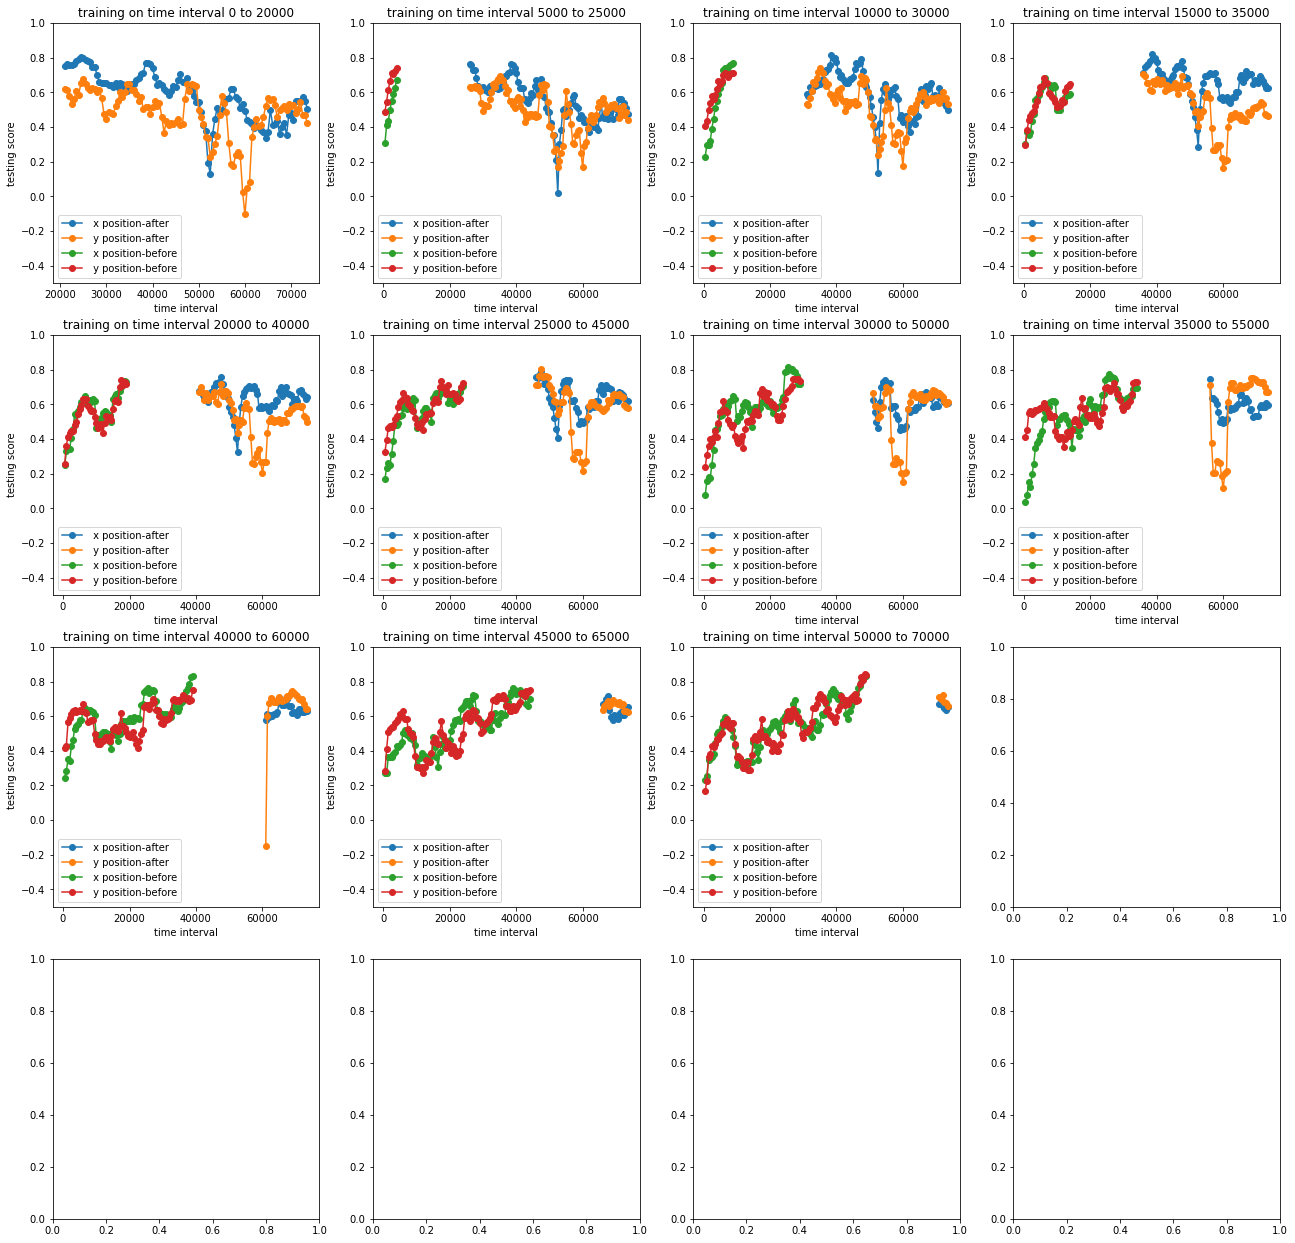

In [311]:
## Training on one timepoint, testing on others
## with buffer ensuring correlations don't affect
## with a sliding window

##file = open('R859_D2_firing_rate_sig_window_30h.pkl','rb')
##inst_fr = pickle.load(file)
inst_fr = np.load('maanasa/DATA/FILES/R859_D2_inst_fr_within.npy')

##inst_fr = inst_fr[:,0:13]
x = np.load('maanasa/DATA/FILES/R859_D2_x_pos_within.npy')
y = np.load('maanasa/DATA/FILES/R859_D2_y_pos_within.npy')


if len(inst_fr)< 100:
    inst_fr = inst_fr.T
##inst_fr = inst_fr[:,0:14]

scaler = StandardScaler()
inst_fr = scaler.fit_transform(inst_fr)
##inst_fr = np.vstack((inst_fr[0:50000,:], inst_fr[60000:,:]))
##x = np.append(x[0:50000], x[60000:])
##y = np.append(y[0:50000], y[60000:])
print(np.shape(inst_fr))

dt = 5000##10000
train_size = 20000##16000
buffer = 1000
test_size = 5000
window = 500

##fig, axs = plt.subplots(2,4,figsize=(22,10))
fig, axs = plt.subplots(4,4,figsize=(22,22))

nrepeats = 1
##for i in range(0, int(np.floor(len(inst_fr)/dt))):
for i in range(0, int(np.floor((len(inst_fr)-train_size)/dt))):
    
    xtest_scores= []
    xtest_scores_other = []
    X_train = inst_fr[i*dt: (i)*dt+ train_size]
    y_train = x[i*dt: (i)*dt+ train_size]
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    ytest_scores= []
    ytest_scores_other = []
    model2 = LinearRegression()
    y_train = y[i*dt: (i)*dt+ train_size]
    model2.fit(X_train, y_train)
    
    all_starts = []
    start = (i)*dt+ train_size + buffer
    print(start)
    while start + window + test_size < len(inst_fr):
        ##if start< 56000 or start> 58000:
            ##xtest_scores.append(model.score( inst_fr[start: start + test_size],x[start: start + test_size]))
            ##ytest_scores.append(model2.score(inst_fr[start: start + test_size] ,y[start: start + test_size]))
            ##if ytest_scores[-1]<-5 and i!= 0:
                ##print(i, start, ytest_scores[-1])

            ##all_starts.append(start)
        all_starts.append(start)
        xtest_scores.append(model.score( inst_fr[start: start + test_size],x[start: start + test_size]))
        ytest_scores.append(model2.score(inst_fr[start: start + test_size] ,y[start: start + test_size]))
        start = start + window
        
    
    all_starts_other = []
    start = (i)*dt- buffer-test_size ##train_size 
    while start >0:
        ##print(start)
        xtest_scores_other.append(model.score( inst_fr[start: start + test_size],x[start: start + test_size]))
        ytest_scores_other.append(model2.score(inst_fr[start: start + test_size] ,y[start: start + test_size]))
        all_starts_other.append(start)
        start = start - window
        
    
    axs[int(np.floor(i/4)),i%4].plot(all_starts, xtest_scores, '-o', label = ' x position-after')
    axs[int(np.floor(i/4)),i%4].plot(all_starts, ytest_scores, '-o', label = ' y position-after')
    axs[int(np.floor(i/4)),i%4].plot(all_starts_other, xtest_scores_other, '-o', label = ' x position-before')
    axs[int(np.floor(i/4)),i%4].plot(all_starts_other, ytest_scores_other, '-o', label = ' y position-before')
    axs[int(np.floor(i/4)),i%4].set_ylim(-0.5, 1)
    axs[int(np.floor(i/4)),i%4].legend()
    axs[int(np.floor(i/4)),i%4].set_xlabel('time interval')
    axs[int(np.floor(i/4)),i%4].set_ylabel('testing score')
    axs[int(np.floor(i/4)),i%4].set_title('training on time interval ' + str(i))
    axs[int(np.floor(i/4)),i%4].set_title('training on time interval ' + str(i*dt) + ' to ' + str((i)*dt+ train_size))

(79107, 39)
starting 0 20000
starting 5000 25000
starting 10000 30000
starting 15000 35000
starting 20000 40000
starting 25000 45000
starting 30000 50000


KeyboardInterrupt: 

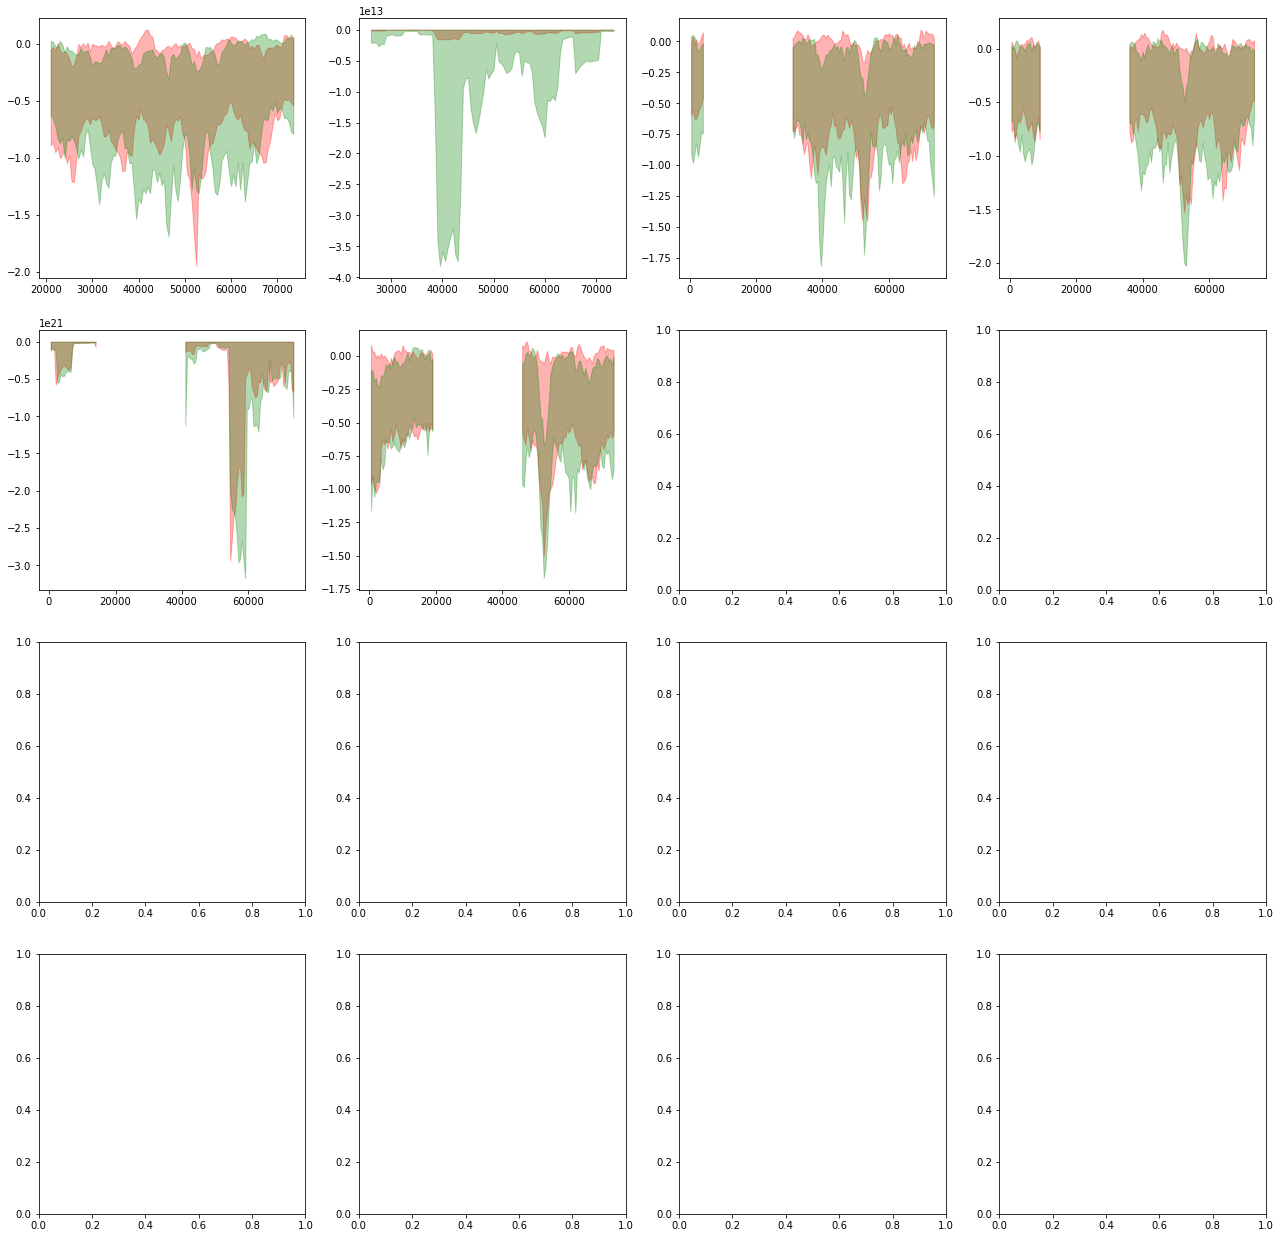

In [401]:

## circular shuffle

inst_fr = np.load('maanasa/DATA/FILES/R859_D2_inst_fr_within.npy')

##inst_fr = inst_fr[:,0:13]
x = np.load('maanasa/DATA/FILES/R859_D2_x_pos_within.npy')
y = np.load('maanasa/DATA/FILES/R859_D2_y_pos_within.npy')


if len(inst_fr)< 100:
    inst_fr = inst_fr.T
##inst_fr = inst_fr[:,0:14]

fig, axs = plt.subplots(4,4,figsize=(22,22))

scaler = StandardScaler()
inst_fr = scaler.fit_transform(inst_fr)
##inst_fr = np.vstack((inst_fr[0:50000,:], inst_fr[60000:,:]))
##x = np.append(x[0:50000], x[60000:])
##y = np.append(y[0:50000], y[60000:])
print(np.shape(inst_fr))

dt = 5000##10000
train_size = 20000##16000
buffer = 1000
test_size = 5000
window = 500

num_shuffles = 1000
alpha_val = 0.3

nrepeats = 1
##for i in range(0, 2):##int(np.floor(len(inst_fr)/dt))):
for i in range(0, int(np.floor((len(inst_fr)-train_size)/dt))):
    print('starting',i*dt, i*dt+ train_size)
    all_xtest_scores= []
    all_xtest_scores_other = []
    all_ytest_scores= []
    all_ytest_scores_other = []
    for shuffling in range(0, num_shuffles):
        inst_fr = np.load('maanasa/DATA/FILES/R859_D2_inst_fr_within.npy')
        shuff_start = np.random.choice(len(inst_fr),1)[0]
        shuff_inst_fr = np.vstack((inst_fr[shuff_start:,:], inst_fr[0:shuff_start,:]))
        inst_fr = shuff_inst_fr
        
        xtest_scores= []
        xtest_scores_other = []
        X_train = inst_fr[i*dt: (i)*dt+ train_size]
        y_train = x[i*dt: (i)*dt+ train_size]
        model = LinearRegression()
        model.fit(X_train, y_train)

        ytest_scores= []
        ytest_scores_other = []
        model2 = LinearRegression()
        y_train = y[i*dt: (i)*dt+ train_size]
        model2.fit(X_train, y_train)

        all_starts = []
        start = (i)*dt+ train_size + buffer
        ##print(shuffling, start)
        while start + window + test_size < len(inst_fr):
            ##print('late',start,start + test_size )
            ##if start< 56000 or start> 58000:
                ##xtest_scores.append(model.score( inst_fr[start: start + test_size],x[start: start + test_size]))
                ##ytest_scores.append(model2.score(inst_fr[start: start + test_size] ,y[start: start + test_size]))
                ##if ytest_scores[-1]<-5 and i!= 0:
                    ##print(i, start, ytest_scores[-1])

                ##all_starts.append(start)
            all_starts.append(start)
            xtest_scores.append(model.score( inst_fr[start: start + test_size],x[start: start + test_size]))
            ytest_scores.append(model2.score(inst_fr[start: start + test_size] ,y[start: start + test_size]))
            start = start + window


        all_starts_other = []
        start = (i)*dt- buffer-test_size 
        while start >0:
            ##print('early', start, start+test_size)
            xtest_scores_other.append(model.score( inst_fr[start: start + test_size],x[start: start + test_size]))
            ytest_scores_other.append(model2.score(inst_fr[start: start + test_size] ,y[start: start + test_size]))
            all_starts_other.append(start)
            start = start - window
        
        all_xtest_scores.append(np.array(xtest_scores))
        all_xtest_scores_other.append(np.array(xtest_scores_other))
        all_ytest_scores.append(np.array(ytest_scores))
        all_ytest_scores_other.append(np.array(ytest_scores_other))
    
    
    alpha = 0.05
    each_side = int((alpha/2)*num_shuffles)

    all_xtest_scores= np.array(all_xtest_scores)
    all_xtest_scores_other= np.array(all_xtest_scores_other)
    all_ytest_scores= np.array(all_ytest_scores)
    all_ytest_scores_other= np.array(all_ytest_scores_other)
    CI_95x1 = []
    CI_95y1 = []
    CI_95x0 = []
    CI_95y0 = []
    CI_95x_other1 = []
    CI_95y_other1 = []
    CI_95x_other0 = []
    CI_95y_other0 = []
    for k in range(len(all_xtest_scores[0])):
        CI_95x1.append(np.sort(all_xtest_scores[:,k])[-each_side])
        CI_95y1.append(np.sort(all_ytest_scores[:,k])[-each_side])
        CI_95x0.append(np.sort(all_xtest_scores[:,k])[each_side])
        CI_95y0.append(np.sort(all_ytest_scores[:,k])[each_side])
    for j in range(len(all_xtest_scores_other[0])):
        CI_95x_other1.append(np.sort(all_xtest_scores_other[:,j])[-each_side])
        CI_95y_other1.append(np.sort(all_ytest_scores_other[:,j])[-each_side])
        CI_95x_other0.append(np.sort(all_xtest_scores_other[:,j])[each_side])
        CI_95y_other0.append(np.sort(all_ytest_scores_other[:,j])[each_side])

    ##axs[int(np.floor(i/4)),i%4].plot(all_starts, CI_95x1, '-o', label = ' x position-after 95CI upper')
    ##axs[int(np.floor(i/4)),i%4].plot(all_starts, CI_95y1, '-o', label = ' y position-after 95CI upper')
    ##axs[int(np.floor(i/4)),i%4].plot(all_starts, CI_95x0, '-o', label = ' x position-after 95CI lower')
    ##axs[int(np.floor(i/4)),i%4].plot(all_starts, CI_95y0, '-o', label = ' y position-after 95CI lower')
    '''axs[int(np.floor(i/4)),i%4].plot(all_starts_other, CI_95x_other1, '-o', label = ' x position-before 95CI upper')
    axs[int(np.floor(i/4)),i%4].plot(all_starts_other, CI_95y_other1, '-o', label = ' y position-before 95CI upper')
    axs[int(np.floor(i/4)),i%4].plot(all_starts_other, CI_95x_other0, '-o', label = ' x position-before 95CI lower')
    axs[int(np.floor(i/4)),i%4].plot(all_starts_other, CI_95y_other0, '-o', label = ' y position-before 95CI lower')'''
    
    axs[int(np.floor(i/4)),i%4].fill_between(all_starts, CI_95x0,CI_95x1, alpha = alpha_val, color = 'red')
    axs[int(np.floor(i/4)),i%4].fill_between(all_starts, CI_95y0,CI_95y1,alpha = alpha_val, color = 'green')
    axs[int(np.floor(i/4)),i%4].fill_between(all_starts_other, CI_95x_other0,CI_95x_other1,alpha = alpha_val,color = 'red')
    axs[int(np.floor(i/4)),i%4].fill_between(all_starts_other, CI_95y_other0,CI_95y_other1,alpha = alpha_val,color = 'green')
    

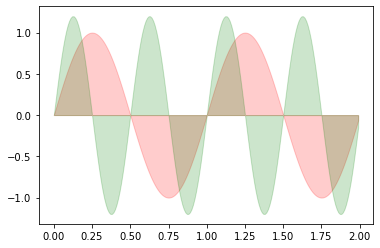

In [400]:
x = np.arange(0.0, 2, 0.01)
y1 = np.sin(2 * np.pi * x)
y2 = 1.2 * np.sin(4 * np.pi * x)

plt.fill_between(x, 0, y1, alpha = 0.2, color = 'red')
plt.fill_between(x, 0, y2, alpha = 0.2, color = 'green')

In [376]:
int(np.floor((len(inst_fr)-train_size)/dt))
##plt.plot(all_starts_other, ytest_scores_other, '-o', label = ' y position-before')

11

In [339]:
np.sort(all_xtest_scores[:,2])[-2]

0.002161847708470943